## Installed packages

In [1]:
#Import packages
import bisect
import datetime
import folium
import functools
import io
import logging
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt, dates
import networkx as nx  
import numpy as np
import os
import pandas as pd
import pickle
import pyproj
import requests
import scipy as sc
import shapely.geometry
from shapely.geometry import Point,Polygon,MultiPolygon
from shapely.ops import transform
import shapely.wkt
import time as timpie
import xarray as xr
import scipy as sc
import yaml
import pytz

#Import packages OpenTNSim
from opentnsim import core
from opentnsim import plot
from opentnsim import model
from opentnsim import import_hydrodynamic_dataset
from opentnsim import vessel_traffic_service
from opentnsim import port
from opentnsim import lock
from opentnsim import vessel as vessel_
from opentnsim import waterway
from opentnsim import output
from opentnsim import tidal_window_constructor
from opentnsim import rule_constructor

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
geod = pyproj.Geod(ellps="WGS84")
pd.set_option('display.max_rows', 500)

In [2]:
# fig,ax = plt.subplots()
# crossings_time = []
# crossings_limit = []
# for loc,info in crossing_dataframe_cvel.iterrows():
#     crossings_time.append(loc)
#     crossings_limit.append(info.Limit)
    
# plt.plot(current_velocity_data.TIME.values,abs(current_velocity_data.values))
# plt.plot(wlev_data.TIME.values,wlev_data.values)
# plt.plot(crossings_time,crossings_limit,'ko',markersize=4)
# for window in windows:
#     plt.fill([window[0],window[1],window[1],window[0]],[-1,-1,2,2],'lightgrey')
# plt.plot(cross_current_limit_dataframe.index.to_numpy(),cross_current_limit_dataframe.Limit.to_numpy(),'k--')
# plt.ylim(-1,2)
# plt.xlim(current_velocity_data.TIME.values[0],current_velocity_data.TIME.values[500]);

In [3]:
# current_velocity_data = hydrodynamic_data['Primary current velocity'][0].mean('LAYER')
# wlev_data = hydrodynamic_data['Astronomic water level'][0]
# tidal_period_data = hydrodynamic_data['Horizontal tidal periods'][0]
# tidal_periods = []
# for condition in tidal_period_data.values:
#     tidal_periods.append([np.datetime64(condition[0]),condition[1]])

In [4]:
# def create_horizontal_tidal_restriction(tidal_periods=[],method='critical current velocity'):
#     if method == 'point-based':
        
#     else:
#         flood_start_times = [time[0] for time in tidal_periods if time[1] == 'Flood Start']
#         ebb_start_times = [time[0] for time in tidal_periods if time[1] == 'Ebb Start']
#         cross_current_limit_dataframe = pd.DataFrame(columns=['Limit','Tide'])
#         for flood_start,ebb_start in zip(flood_start_times,ebb_start_times):
#             cross_current_limit_dataframe.at[flood_start-np.timedelta64(1,'ns'),'Limit'] = -1.0
#             cross_current_limit_dataframe.at[flood_start-np.timedelta64(1,'ns'),'Tide'] = 'Ebb'
#             cross_current_limit_dataframe.at[flood_start,'Limit'] = 1.0
#             cross_current_limit_dataframe.at[flood_start,'Tide'] = 'Flood'
#             cross_current_limit_dataframe.at[ebb_start-np.timedelta64(1,'ns'),'Limit'] = 1.0
#             cross_current_limit_dataframe.at[ebb_start-np.timedelta64(1,'ns'),'Tide'] = 'Flood'
#             cross_current_limit_dataframe.at[ebb_start,'Limit'] = -1.0
#             cross_current_limit_dataframe.at[ebb_start,'Tide'] = 'Ebb'
#         cross_current_limit_dataframe['Limit'] = cross_current_limit_dataframe.Limit.astype(float) 
#     return cross_current_limit_dataframe

## Some functions

In [5]:
@functools.lru_cache
def load_fis_network(url):
    """load the topological fairway information system network (vaarweginformatie.nl)"""

    # get the data from the url
    resp = requests.get(url)
    # convert to file object
    stream = io.StringIO(resp.text)
    
    # This will take a minute or two
    # Here we convert the network to a networkx object
    G = yaml.load(stream, Loader=yaml.Loader)

    # some brief info
    n_bytes = len(resp.content)
    msg = '''Loaded network from {url} file size {mb:.2f}MB. Network has {n_nodes} nodes and {n_edges} edges.'''
    summary = msg.format(url=url, mb=n_bytes / 1000**2, n_edges=len(G.edges), n_nodes=len(G.nodes))
    logger.info(summary)

    # The topological network contains information about the original geometry. 
    # Let's convert those into python shapely objects for easier use later
    for n in G.nodes:
        G.nodes[n]['geometry'] = shapely.geometry.Point(G.nodes[n]['X'], G.nodes[n]['Y'])
    for e in G.edges:
        edge = G.edges[e]
        edge['geometry'] = shapely.wkt.loads(edge['Wkt'])
        edge['length'] = edge_length(edge)    
    
    return G 

def edge_length(edge):
    """compute the great circle length of an edge
    The network version 0.1 contains the lat/lon distance in a length property. 
    But we need the "great circle" or projected distance. 
    Let's define a function to recompute it.
    """
    
    # get the geometry
    geom = edge['geometry']
    # get lon, lat
    lats, lons = np.array(geom).T
    # this requires pyproj 2.3.0
    distance = geod.line_length(lons, lats)

    return distance

def find_closest_edge(G, point):
    """find the closest edge on the graph from a given point"""
    
    distance = np.full((len(G.edges)), fill_value=np.nan)
    for ii, e in enumerate(G.edges):
        distance[ii] = point.distance(G.edges[e]['geometry'])
    name_edge = list(G.edges)[np.argmin(distance)]
    distance_edge = np.min(distance)
    
    return name_edge, distance_edge

def find_closest_node(G, point):
    """find the closest node on the graph from a given point"""
    
    distance = np.full((len(G.nodes)), fill_value=np.nan)
    for ii, n in enumerate(G.nodes):
        distance[ii] = point.distance(G.nodes[n]['geometry'])
    name_node = list(G.nodes)[np.argmin(distance)]
    distance_node = np.min(distance)
    
    return name_node, distance_node

def add_edge_to_network(FG,node1,node2):
    Info = {}
    Info['length'] = pyproj.Geod(ellps="WGS84").inv(FG.nodes[node1]['geometry'].x,
                                                    FG.nodes[node1]['geometry'].y,
                                                    FG.nodes[node2]['geometry'].x,
                                                    FG.nodes[node2]['geometry'].y,)[2]
    Info['geometry'] = shapely.geometry.LineString([FG.nodes[node1]['geometry'], FG.nodes[node2]['geometry']])
    geometry = Info['geometry']
    FG.add_edge(node1, node2, Info=Info, geometry=geometry)
    return

def calculate_distance(project,route):
    distance = 0
    for node1,node2 in zip(route[:-1],route[1:]):
        if 'length' in FG.edges[node1,node2,0]['Info']:
            distance += FG.edges[node1,node2,0]['Info']['length']
        else:
            line = FG.edges[node1,node2,0]['Info']['geometry']
            distance += transform(project, line).length
            
    return distance

def color_vessels(vessel,min_linewidth = 0.5,max_linewidth = 3,cmap = mpl.cm.get_cmap('Set1_r'),
                  draught_distribution = [4.6,5.6,8.7,10.25,11.7,12.4,13.95,15.0]):
    
    vessel_norm = mpl.colors.BoundaryNorm(boundaries=list(draught_distribution),ncolors=len(draught_distribution))
    vessel_cmap = cmap
    
    if str(type(vessel)) == "<class '__main__.Vessel'>":
        linewidth = vessel.T_f/(draught_distribution[-1]-draught_distribution[0])*max_linewidth+min_linewidth
        for c in enumerate(vessel_cmap.colors[1:(len(draught_distribution)+1)]):
            if vessel.T_f >= vessel_norm.boundaries[c[0]]:
                color = c[1]
            else:
                break
    else:
        color = []
        linewidth = []
        for draught in vessel:
            linewidth.append(draught/(draught_distribution[-1]-draught_distribution[0])*max_linewidth+min_linewidth)
        for c in enumerate(vessel_cmap.colors[1:(len(draught_distribution)+1)]):
            color.append(c[1])
        
    return color,linewidth

def vessel_legend(axis,start_time,min_linewidth = 0.5,max_linewidth = 3,cmap = mpl.colorbar.cm.tab10,
                  vessel_types=['Small Coaster 1','Small Coaster 2','Coaster','Handysize','Medium Range','Long Range 1','Long Range 2 I','Long Range 2 II'],
                  draught_distribution = [4.6,5.6,8.7,10.25,11.7,12.4,13.95,15.0]):               

    vessel_norm = mpl.colors.BoundaryNorm(boundaries=list(draught_distribution),ncolors=len(draught_distribution))
    vessel_cmap = cmap
    
    ylim = axis.axes.get_xlim()
    colors,linestyles = color_vessels(draught_distribution)
    for vtype in enumerate(vessel_types):
        axis.plot([-1000,-1000],[start_time-1000,start_time-1000],
                  color=colors[vtype[0]],
                  label=str(vtype[1]))
    leg= axis.legend(loc='lower right',handlelength=8,ncol=2,bbox_to_anchor=(0.95, -0.25),frameon=False)
    for line in leg.get_lines():
        line.set_linewidth((max_linewidth-min_linewidth)*0.5+min_linewidth)
        
    axis.plot([-1000,-1000],[start_time-1000,start_time-1000],
             color='k',
             linewidth = draught_distribution[0]/(draught_distribution[-1]-draught_distribution[0])*max_linewidth+min_linewidth,
             label=str(round(draught_distribution[0],2)) +' m')
                                                  
    for vtype in enumerate(vessel_types):
        axis.plot([-1000,-1000],[start_time-1000,start_time-1000],
                 color='k',
                 linewidth = draught_distribution[vtype[0]]/(draught_distribution[-1]-draught_distribution[0])*max_linewidth+min_linewidth,
                 label=str(round(draught_distribution[vtype[0]],2)) +' m')
    plt.legend(loc='lower right',handlelength=9,ncol=3,bbox_to_anchor=(1.35, -0.215),frameon=False)

def tidal_window_visualization(origin,FG,start_time,end_time,start_node,end_node,T_lower_limit,T_upper_limit,T_ticks,bound):
    T_list = np.arange(T_lower_limit,T_upper_limit,T_ticks)
    route = nx.dijkstra_path(FG, start_node, end_node)
    vessels = []
    for draught in T_list:
        vessels.append(Vessel(FG=FG,
                              start_time = simulation_start.timestamp(),
                              name = 'Tanker',
                              T = draught,
                              L = 149,
                              v = 4.5,
                              B = 27,
                              ukc = 0,
                              mccur = 0,
                              mwt = end_time-start_time,
                              bound = bound,
                              typ = 'Handysize',
                              network = FG,
                              start_node = start_node,
                              end_node = end_node,
                              sailing_time_to_terminal=0))
        
    sail_in_times_tidal_window = []
    for vessel in vessels:
        sail_in_times_tidal_window.append(env.vessel_traffic_service.provide_sail_in_times_tidal_window(vessel,vessel.route))

    corrected_sail_in_times_tidal_window = []
    for sail_in_times_tidal_windows_vessel in sail_in_times_tidal_window:
        corrected_sail_in_times_tidal_window_vessel = []
        if sail_in_times_tidal_windows_vessel[0] != []:
            if sail_in_times_tidal_windows_vessel[0][1] == 'Stop':
                corrected_sail_in_times_tidal_window.append([[sail_in_times_tidal_windows_vessel[0][t[0]-1][0],t[1][0]] for t in enumerate(sail_in_times_tidal_windows_vessel[0]) if t[1][1] == 'Start'])
            else:
                corrected_sail_in_times_tidal_window.append([[t[1][0],sail_in_times_tidal_windows_vessel[0][t[0]+1][0]] for t in enumerate(sail_in_times_tidal_windows_vessel[0]) if t[1][1] == 'Stop' and t[0] != len(sail_in_times_tidal_windows_vessel[0])-1])
        else:
            corrected_sail_in_times_tidal_window.append([[start_time,end_time],
                                                         [start_time,end_time]])                              
    
    indexes = []
    timestamp = []
    for corrected_sail_in_times in corrected_sail_in_times_tidal_window:
        for times in corrected_sail_in_times:
            timestamp.extend([times[0],times[1]])
    timestamp.sort()
    timestamp = list(dict.fromkeys(timestamp))

    timestamps = []
    timestamps.append(start_time)
    for time_index,time in enumerate(timestamp):
        if time_index != 0 and time_index != len(timestamp)-1:
            timestamps.extend([time,time])
        else:
            timestamps.append(time)
    timestamps.append(end_time)
    
    values = np.zeros(len(timestamps))    
    for vessel_index,corrected_sail_in_times_tidal_window_vessel in enumerate(corrected_sail_in_times_tidal_window):
        for time_index,time_tidal_window in enumerate(corrected_sail_in_times_tidal_window_vessel):
            if time_tidal_window[1] <= end_time:
                indx1 = timestamps.index(time_tidal_window[0])
                indx2 = timestamps.index(time_tidal_window[1])
                if indx2 != len(timestamps)-1 and time_tidal_window[1] != end_time:
                    if indx1 != 0:
                        indx1 = indx1+1
                    for indx,_ in enumerate(timestamps[indx1:indx2+1]):
                        values[indx+indx1] = vessels[vessel_index].T_f
                else:
                    if indx1 != 0:
                        indx1 = indx1+1
                        for indx,_ in enumerate(timestamps[indx1:]):
                            values[indx+indx1] = vessels[vessel_index].T_f
                    else:
                        for indx,_ in enumerate(timestamps):
                            values[indx] = vessels[vessel_index].T_f
                        break
            elif time_tidal_window[0] <= end_time:
                indx1 = timestamps.index(time_tidal_window[0])+1
                for indx,_ in enumerate(timestamps[indx1:]):
                    values[indx+indx1] = vessels[vessel_index].T_f

    distance = calculate_distance(project,nx.dijkstra_path(FG,origin,end_node))

    locations = list(distance*np.ones(len(timestamps)))
    indexes = nx.dijkstra_path(FG,origin,end_node).index(start_node)*np.ones(len(timestamps))

    return indexes,locations,timestamps,values

def create_tidal_window_tiles(FG,origin,start_time,end_time,start_node,end_node,bound):
    I = []
    X = []
    Y = []
    Z = []
    route = nx.dijkstra_path(FG,start_node,end_node)
    T_lower_limit = 4.5
    T_ticks = 0.05
    T_upper_limit = 16+T_ticks
    for node in enumerate(route):
        i,x,y,z = tidal_window_visualization(origin,FG,start_time,end_time,node[1],node[1],T_lower_limit,T_upper_limit,T_ticks,bound)
        I.append(i)
        X.append(x)
        Y.append(y)
        Z.append(z)
    
    x_int = []
    y_int = []
    z_int = []
    
    for x in enumerate(X):  
        intrp = sc.interpolate.interp1d(Y[x[0]],Z[x[0]])
        y_intrp = np.linspace(start_time,end_time,1000)
        x_intrp = x[1][0]*np.ones(1000)
        z_intrp = intrp(y_intrp)
        x_int.append(x_intrp)
        y_int.append(y_intrp)
        z_int.append(z_intrp)
    
    return x_int,y_int,z_int

def plot_tidal_window_tiles(axis,x_int,y_int,z_int,norm,cmap):
    if len(y_int) > 3:
        for y in enumerate(y_int[0]):
            x_intrp_old = [x[y[0]] for x in x_int]
            z_intrp_old = [z[y[0]] for z in z_int]
            intrp = sc.interpolate.interp1d(x_intrp_old,z_intrp_old,fill_value='extrapolate')
            x_intrp = np.linspace(0,axis.axes.get_xlim()[1],1000)
            y_intrp = y[1]*np.ones(1000)
            z_intrp = intrp(x_intrp)
            axis.scatter(x_intrp,y_intrp,s=2,c=z_intrp,norm=norm,cmap=cmap)
        
    else:
        for y in enumerate(y_int[0]):
            x_intrp_old = [[x for x in x_int][0][y[0]]-100,[x for x in x_int][0][y[0]]+100]
            z_intrp_old = [[z for z in z_int][0][y[0]],[z for z in z_int][0][y[0]]]
            intrp = sc.interpolate.interp1d(x_intrp_old,z_intrp_old,fill_value='extrapolate')
            x_intrp = np.linspace(-100+horizontal_tidal_restriction_distance,100+horizontal_tidal_restriction_distance,1000)
            y_intrp = y[1]*np.ones(1000)
            z_intrp = intrp(x_intrp)
            axis.scatter(x_intrp,y_intrp,s=2,c=z_intrp,norm=norm,cmap=cmap)  
    return

## Simulation settings

In [6]:
simulation_start = datetime.datetime(2019,1,1,0,0,0).replace(tzinfo=pytz.utc)
simulation_stop = datetime.datetime(2020,1,1,0,0,0).replace(tzinfo=pytz.utc)

## Import FIS network

In [7]:
url = 'https://zenodo.org/record/4578289/files/network_digital_twin_v0.2.yaml'

# create a cached version to speed up loading (remove cached file if a better yaml file is available)
fname = "fis_cache\\{}.pkl".format('FIS')

if os.path.exists(fname):
    print('I am loading cached network')
    with open(fname, 'rb') as pkl_file:
        FG = pickle.load(pkl_file)
        pkl_file.close()

else:
    print('I am getting new network')
    FG = load_fis_network(url)

    os.makedirs(os.path.dirname(fname), exist_ok=True)
    with open(fname, 'wb') as pkl_file:
        pickle.dump(FG, pkl_file)
        pkl_file.close()

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_20952\3682999432.py:9: UserWarning:

Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.



I am loading cached network


## Selection area of the Port of Rotterdam

In [8]:
polygon = shapely.geometry.Polygon([[4.047046106288641, 51.994530949601149, 0.0 ], [ 4.041820334307678, 51.985794447379547, 0.0 ], [ 4.032638009410599, 51.987359301430168, 0.0 ], [ 4.026085029365865, 51.986529814588927, 0.0 ], [ 4.023082985071111, 51.985502004661448, 0.0 ], [ 4.00823290473104, 51.988174970713708, 0.0 ], [ 3.998553814899393, 51.987323088053131, 0.0 ], [ 3.987086024543889, 51.983489630873457, 0.0 ], [ 3.980367408521741, 51.978923864007278, 0.0 ], [ 3.972858821044363, 51.972254400764548, 0.0 ], [ 3.964975414140348, 51.962100235646908, 0.0 ], [ 3.965767078274776, 51.958192943818972, 0.0 ], [ 3.9714783688349, 51.946631494630573, 0.0 ], [ 3.983298387670107, 51.927838319363971, 0.0 ], [ 3.987657598176972, 51.919192330532567, 0.0 ], [ 3.996387468717351, 51.916655170259958, 0.0 ], [ 4.001520162387755, 51.917060309257401, 0.0 ], [ 4.012557173047844, 51.920229693122977, 0.0 ], [ 4.048001660981074, 51.929016004063037, 0.0 ], [ 4.074660383723856, 51.934902766449348, 0.0 ], [ 4.093265372959262, 51.934893193914142, 0.0 ], [ 4.109255167927888, 51.93372388247014, 0.0 ], [ 4.126734837924461, 51.932516710383318, 0.0 ], [ 4.139980260895813, 51.931607190411903, 0.0 ], [ 4.147852124552989, 51.929605717664337, 0.0 ], [ 4.154871093926527, 51.92643205114458, 0.0 ], [ 4.164068865894088, 51.922235472642527, 0.0 ], [ 4.168497166059588, 51.919961894548123, 0.0 ], [ 4.173765785457206, 51.917888566713337, 0.0 ], [ 4.177471853896762, 51.916075611730989, 0.0 ], [ 4.19143525340012, 51.910078064370317, 0.0 ], [ 4.202511571167557, 51.904617634287582, 0.0 ], [ 4.212615864448434, 51.899592844692521, 0.0 ], [ 4.219017538516361, 51.895881651452001, 0.0 ], [ 4.223832400198837, 51.890530353414427, 0.0 ], [ 4.226873738466466, 51.887326711590937, 0.0 ], [ 4.228951660169189, 51.883411780650917, 0.0 ], [ 4.230693981376918, 51.879498998972053, 0.0 ], [ 4.23245567320008, 51.876804618361149, 0.0 ], [ 4.235713735314597, 51.874394644882933, 0.0 ], [ 4.240860704028409, 51.871936856471507, 0.0 ], [ 4.246713039932697, 51.869742419056138, 0.0 ], [ 4.256500276768536, 51.866468683159347, 0.0 ], [ 4.263681165876234, 51.864338061762467, 0.0 ], [ 4.270856008579235, 51.864165082808469, 0.0 ], [ 4.277892120705451, 51.86439728390355, 0.0 ], [ 4.286849974208358, 51.8645882221536, 0.0 ], [ 4.292522161762808, 51.864277013800361, 0.0 ], [ 4.299811679854974, 51.864101583593218, 0.0 ], [ 4.311303788739909, 51.864116069612663, 0.0 ], [ 4.329734623050854, 51.864276123508454, 0.0 ], [ 4.331499517754396, 51.864024053521959, 0.0 ], [ 4.333688920564924, 51.862880975070347, 0.0 ], [ 4.336262605418339, 51.859939034098609, 0.0 ], [ 4.34137585560622, 51.854360268676722, 0.0 ], [ 4.351538393640837, 51.847648283939193, 0.0 ], [ 4.362976373927347, 51.843831785091027, 0.0 ], [ 4.370084445558557, 51.841582728647857, 0.0 ], [ 4.380089933091171, 51.840617401653859, 0.0 ], [ 4.391081067036453, 51.839898516477582, 0.0 ], [ 4.399478875843261, 51.840163345822617, 0.0 ], [ 4.408773767123155, 51.841091522022268, 0.0 ], [ 4.416943663050734, 51.840074266710687, 0.0 ], [ 4.423210503951149, 51.838579340029192, 0.0 ], [ 4.427503697165283, 51.836513860483983, 0.0 ], [ 4.425576770167599, 51.834095807664362, 0.0 ], [ 4.429533318178938, 51.832633476567118, 0.0 ], [ 4.430960005176178, 51.833741029897993, 0.0 ], [ 4.434887510360975, 51.833765267256481, 0.0 ], [ 4.43690383938546, 51.83312364379659, 0.0 ], [ 4.444075259200149, 51.831057027288622, 0.0 ], [ 4.455433085635423, 51.829280289923247, 0.0 ], [ 4.46771578321205, 51.829690776121659, 0.0 ], [ 4.478878685926199, 51.830795076878637, 0.0 ], [ 4.488164498900886, 51.832451656061437, 0.0 ], [ 4.497474736200315, 51.832277533876983, 0.0 ], [ 4.504006118328753, 51.831563991137351, 0.0 ], [ 4.512048063063212, 51.829681547431278, 0.0 ], [ 4.52023617846478, 51.827734951843553, 0.0 ], [ 4.527396173112097, 51.827099310549393, 0.0 ], [ 4.533930342872021, 51.828087046218492, 0.0 ], [ 4.54119648874229, 51.829604882537978, 0.0 ], [ 4.546648500960357, 51.829305402579081, 0.0 ], [ 4.552248982461713, 51.827676804936857, 0.0 ], [ 4.554747912727908, 51.824662856298893, 0.0 ], [ 4.557658515089615, 51.818037740135757, 0.0 ], [ 4.562338329955282, 51.812146737080482, 0.0 ], [ 4.567790268643788, 51.808872879868893, 0.0 ], [ 4.575257216434827, 51.80678730057928, 0.0 ], [ 4.58251573514719, 51.805521253772739, 0.0 ], [ 4.590037627731165, 51.805171699165371, 0.0 ], [ 4.597774284387466, 51.804055987532443, 0.0 ], [ 4.604313450900881, 51.802297307784549, 0.0 ], [ 4.613475866941057, 51.800235897440317, 0.0 ], [ 4.617341098435928, 51.798124369718323, 0.0 ], [ 4.618362378336296, 51.796181342994132, 0.0 ], [ 4.621252023873148, 51.790276378816401, 0.0 ], [ 4.62409979956345, 51.782635434416783, 0.0 ], [ 4.623941953031045, 51.77630929086952, 0.0 ], [ 4.623064754206448, 51.763389962802563, 0.0 ], [ 4.624433481891639, 51.757517082463593, 0.0 ], [ 4.627814435262847, 51.75075427110778, 0.0 ], [ 4.627879472881458, 51.743955186361127, 0.0 ], [ 4.626354092832785, 51.736179071181077, 0.0 ], [ 4.623290219595805, 51.726941768179799, 0.0 ], [ 4.619409050652274, 51.721750961942199, 0.0 ], [ 4.616120550381302, 51.716182645862659, 0.0 ], [ 4.609566079180749, 51.709477107202552, 0.0 ], [ 4.605050592100282, 51.705466495857721, 0.0 ], [ 4.600730591394282, 51.702608721228763, 0.0 ], [ 4.593484968687383, 51.700694538430596, 0.0 ], [ 4.578029217511245, 51.698311310158317, 0.0 ], [ 4.566507458151197, 51.695868601503108, 0.0 ], [ 4.556646021680121, 51.694506492441057, 0.0 ], [ 4.544885547002719, 51.692528879578767, 0.0 ], [ 4.546338018922178, 51.687750048814117, 0.0 ], [ 4.567420841100791, 51.69114986797571, 0.0 ], [ 4.568815806261195, 51.688246505711163, 0.0 ], [ 4.574402919128991, 51.673642115923442, 0.0 ], [ 4.582440212968, 51.675045873653353, 0.0 ], [ 4.603759922942611, 51.67909424032014, 0.0 ], [ 4.609000212678733, 51.682787850019203, 0.0 ], [ 4.61322770400086, 51.687589032555543, 0.0 ], [ 4.616346068304478, 51.688505385639402, 0.0 ], [ 4.618177114470288, 51.689083597445311, 0.0 ], [ 4.611503886862787, 51.700539553693048, 0.0 ], [ 4.618547235224733, 51.704758620916408, 0.0 ], [ 4.621188579458506, 51.70912483940171, 0.0 ], [ 4.625278654281832, 51.71853614447808, 0.0 ], [ 4.62895981688983, 51.726591934181187, 0.0 ], [ 4.631015273970891, 51.731345868647637, 0.0 ], [ 4.632270606035429, 51.73633287458577, 0.0 ], [ 4.634070893980669, 51.74383147071385, 0.0 ], [ 4.633874592083471, 51.752192752634713, 0.0 ], [ 4.630948981882912, 51.759574802772647, 0.0 ], [ 4.629120910421564, 51.765486142676011, 0.0 ], [ 4.629532349597874, 51.770814439938789, 0.0 ], [ 4.630894904718586, 51.77947979515762, 0.0 ], [ 4.630205119517427, 51.784593728340461, 0.0 ], [ 4.644155121160485, 51.784738066131723, 0.0 ], [ 4.64675789658717, 51.785521955122, 0.0 ], [ 4.648523080480585, 51.787655536083861, 0.0 ], [ 4.648380883747016, 51.791059131401887, 0.0 ], [ 4.648653816976214, 51.797693391205897, 0.0 ], [ 4.64901104999494, 51.806929426135078, 0.0 ], [ 4.649005053746082, 51.807578765213528, 0.0 ], [ 4.644316669744375, 51.808880483719882, 0.0 ], [ 4.641063113733887, 51.807100885321567, 0.0 ], [ 4.636305758391581, 51.805050274482483, 0.0 ], [ 4.631933508015191, 51.803574293533259, 0.0 ], [ 4.626968120311867, 51.802438675475052, 0.0 ], [ 4.620497311172034, 51.802272999154503, 0.0 ], [ 4.615951679076103, 51.803311401541073, 0.0 ], [ 4.606272307986039, 51.806284851480697, 0.0 ], [ 4.596159971591947, 51.808126778121583, 0.0 ], [ 4.586158031535925, 51.808844780132617, 0.0 ], [ 4.579447886128047, 51.810058867002901, 0.0 ], [ 4.573060189604023, 51.812295490473929, 0.0 ], [ 4.566012519971096, 51.815434547502242, 0.0 ], [ 4.563773566221736, 51.818687634757516, 0.0 ], [ 4.563201599006845, 51.821957279842117, 0.0 ], [ 4.562968089313304, 51.824543181240337, 0.0 ], [ 4.558540613429947, 51.82964006740454, 0.0 ], [ 4.552433393126092, 51.832316314254932, 0.0 ], [ 4.545014088655261, 51.834290234059893, 0.0 ], [ 4.537158070334188, 51.833393779336141, 0.0 ], [ 4.530038207031499, 51.832102384556208, 0.0 ], [ 4.526108059542169, 51.831813208714102, 0.0 ], [ 4.521717619046028, 51.832590425155978, 0.0 ], [ 4.516732521897168, 51.833960245101871, 0.0 ], [ 4.514236527391809, 51.834496902354807, 0.0 ], [ 4.509974165494395, 51.83553112330867, 0.0 ], [ 4.501820011750192, 51.837106988151767, 0.0 ], [ 4.495840125581275, 51.837258622122228, 0.0 ], [ 4.486864901019976, 51.837137748460393, 0.0 ], [ 4.478183135596048, 51.83618389210767, 0.0 ], [ 4.472439264345458, 51.835228495563783, 0.0 ], [ 4.461775016379061, 51.833908716258769, 0.0 ], [ 4.453922237117189, 51.833744056940958, 0.0 ], [ 4.445880993540623, 51.83521472745835, 0.0 ], [ 4.433867160146994, 51.838656519273393, 0.0 ], [ 4.42470273645797, 51.841440135427547, 0.0 ], [ 4.42153152386223, 51.842243381585881, 0.0 ], [ 4.412288631756962, 51.844837057595839, 0.0 ], [ 4.404628276058093, 51.845147332925059, 0.0 ], [ 4.394141940257916, 51.844056513242528, 0.0 ], [ 4.385970084449699, 51.84384058231597, 0.0 ], [ 4.38009310776012, 51.844281463545563, 0.0 ], [ 4.36989301637785, 51.845910018863457, 0.0 ], [ 4.360483758821787, 51.848313888858193, 0.0 ], [ 4.354349626537848, 51.851008172324264, 0.0 ], [ 4.347909504952052, 51.855404628831913, 0.0 ], [ 4.342408539850937, 51.86054970135617, 0.0 ], [ 4.337899232746361, 51.865294765331257, 0.0 ], [ 4.335433216951134, 51.869785988478348, 0.0 ], [ 4.333552618008243, 51.873809653870651, 0.0 ], [ 4.348428925913814, 51.875946272051308, 0.0 ], [ 4.369163929813908, 51.878317553006468, 0.0 ], [ 4.38839016518595, 51.87815521453539, 0.0 ], [ 4.401107220355129, 51.877058298559803, 0.0 ], [ 4.426040664379522, 51.873026806667077, 0.0 ], [ 4.437079597260853, 51.871386012190683, 0.0 ], [ 4.448943520990141, 51.871564030747429, 0.0 ], [ 4.454263046403941, 51.871932213390657, 0.0 ], [ 4.454612554075805, 51.876499560242912, 0.0 ], [ 4.461854063353627, 51.892501464714812, 0.0 ], [ 4.466785298039618, 51.894872117693943, 0.0 ], [ 4.472093734132137, 51.894358029456889, 0.0 ], [ 4.475597745139166, 51.893088291767661, 0.0 ], [ 4.495575011014354, 51.897022475135103, 0.0 ], [ 4.497482873128506, 51.904708775055248, 0.0 ], [ 4.483610341771596, 51.910345930077462, 0.0 ], [ 4.482760758326021, 51.909513132342788, 0.0 ], [ 4.481354888673367, 51.907659452044847, 0.0 ], [ 4.480171615622785, 51.906587418413928, 0.0 ], [ 4.478656007166948, 51.905614334220239, 0.0 ], [ 4.47420728963661, 51.903986716234108, 0.0 ], [ 4.468091888502901, 51.902252150225287, 0.0 ], [ 4.465003985162294, 51.907646878763657, 0.0 ], [ 4.462309529254382, 51.906989997256652, 0.0 ], [ 4.458607445683542, 51.904702185072551, 0.0 ], [ 4.450510265256744, 51.902876957622773, 0.0 ], [ 4.444600706587229, 51.903309513507153, 0.0 ], [ 4.440641527550353, 51.905721770934349, 0.0 ], [ 4.43802672176208, 51.907881366164169, 0.0 ], [ 4.432905776054799, 51.910555872287738, 0.0 ], [ 4.426112874198747, 51.912467834061907, 0.0 ], [ 4.422383819883729, 51.913168929583513, 0.0 ], [ 4.411878223585475, 51.913540129396402, 0.0 ], [ 4.409521680173807, 51.911005537418113, 0.0 ], [ 4.409980373031104, 51.907863380341098, 0.0 ], [ 4.410238903774557, 51.905760620712883, 0.0 ], [ 4.40792824029834, 51.905695231506868, 0.0 ], [ 4.408236980724604, 51.901856095046021, 0.0 ], [ 4.402375508953853, 51.900192780344398, 0.0 ], [ 4.398972492127681, 51.899588847278451, 0.0 ], [ 4.398510798786443, 51.904247434360137, 0.0 ], [ 4.397094621487874, 51.90646667642546, 0.0 ], [ 4.385614359534216, 51.907989085010612, 0.0 ], [ 4.378087964881123, 51.909686675033377, 0.0 ], [ 4.374128281325, 51.908694908241579, 0.0 ], [ 4.367852653269681, 51.908306138351691, 0.0 ], [ 4.363397244884773, 51.909430864627993, 0.0 ], [ 4.356519147274849, 51.906592072056007, 0.0 ], [ 4.349296405899398, 51.904046653826121, 0.0 ], [ 4.348244134194987, 51.903702932010567, 0.0 ], [ 4.349406111299523, 51.899790994706308, 0.0 ], [ 4.344160954128946, 51.898618840978919, 0.0 ], [ 4.335081568788706, 51.896868371347999, 0.0 ], [ 4.326200276202865, 51.896412521739443, 0.0 ], [ 4.32457076936686, 51.900817957716093, 0.0 ], [ 4.319738626071643, 51.900546337822448, 0.0 ], [ 4.307247475566158, 51.900885572136751, 0.0 ], [ 4.276804688291795, 51.907441861806603, 0.0 ], [ 4.260087950487823, 51.913551219808411, 0.0 ], [ 4.25162487299372, 51.91669563964313, 0.0 ], [ 4.248376913383156, 51.91449410685788, 0.0 ], [ 4.245717112143339, 51.915364621818703, 0.0 ], [ 4.243630834376155, 51.916354360761702, 0.0 ], [ 4.235899751919456, 51.921703697987638, 0.0 ], [ 4.228306802315593, 51.928844045846439, 0.0 ], [ 4.215768636252541, 51.935587344495282, 0.0 ], [ 4.199751571089035, 51.941361577730078, 0.0 ], [ 4.187845586291519, 51.946336059832333, 0.0 ], [ 4.174792346056993, 51.952774770268881, 0.0 ], [ 4.160900691414067, 51.960268474450572, 0.0 ], [ 4.143905642848278, 51.96883626854671, 0.0 ], [ 4.128162638085904, 51.9746278367287, 0.0 ], [ 4.125530375394987, 51.975262010141122, 0.0 ], [ 4.120117786508599, 51.977185994794318, 0.0 ], [ 4.116406216069988, 51.978663950477113, 0.0 ], [ 4.10945387129291, 51.981203138086038, 0.0 ], [ 4.093364376007981, 51.984944583465733, 0.0 ], [ 4.047046106288641, 51.994530949601149, 0.0 ] ] )

#Select nodes and edges within the polygon
nodes = []
edges = []
node_names = []

for edge in FG.edges(data = True):
    node_1 = FG.nodes[edge[0]]
    node_2 = FG.nodes[edge[1]]
    
    if node_1["geometry"].within(polygon) or node_2["geometry"].within(polygon):
        nodes.append(node_1)
        nodes.append(node_2)
        node_names.append(edge[0])
        node_names.append(edge[1])
        edges.append(edge)

In [9]:
#Create a new network
FG = nx.MultiDiGraph()

#Add nodes and edges that fell within the polygon
for node,node_name in zip(nodes,node_names):
    FG.add_node(node_name, geometry = node["geometry"])

for edge in edges:
    FG.add_edge(edge[0], edge[1], Info = edge[2], geometry=edge[2]["geometry"]) 

#Further manual adjustments of the network
FG.add_node('8866969B',geometry=FG.nodes['8866969']['geometry'])
add_edge_to_network(FG,'8866969','8866969B')

FG.add_node('8866969A',geometry=FG.nodes['8866969']['geometry'])
add_edge_to_network(FG,'8866969B','8866969A')

FG.add_node('8866969C',geometry=FG.nodes['8866969']['geometry'])
add_edge_to_network(FG,'8866969C','8866969B')

add_edge_to_network(FG,'B57361_A','B7951_B')

for i in range(3):
    FG.remove_edge(find_closest_edge(FG,shapely.geometry.Point([4.488648,51.908018]))[0][0],find_closest_edge(FG,shapely.geometry.Point([4.488648,51.908018]))[0][1])

nodes_to_be_removed = ['8860852','B4705_A','B4705_B','B45486_B','L4199_A','B27780191_A','B27780191_B','8867741','B23888_B','B23888_A','L6951_B','L6951_A','L43910_B','L43910_A','B16957_B','B57921_A','L57066_B','L57066_A']
for n in nodes_to_be_removed:
    FG.remove_node(n)

C:\Users\floorbakker\Anaconda3\envs\opentnsim\lib\site-packages\shapely\measurement.py:74: RuntimeWarning:

invalid value encountered in distance



In [10]:
#Make network bidirectional
FG = FG.to_undirected()

In [11]:
FG.add_node('anchorage',geometry=FG.nodes['8866969']['geometry'])

In [12]:
add_edge_to_network(FG,'8866969','anchorage')

In [13]:
#Plot network
m = folium.Map(location=[52.0, 3.5], zoom_start = 9, tiles="cartodbpositron")

for node in FG.nodes(data = True):
    points_x = list(node[1]["geometry"].coords.xy[0])
    points_y = list(node[1]["geometry"].coords.xy[1])
    
    point = []
    for i, _ in enumerate(points_x):
        point.append((points_y[i], points_x[i]))
    else:
        folium.Circle(point[0], radius=12,fill=True,fill_opacity=1,tooltip = node[0],popup =node[0]).add_to(m)

for edge in FG.edges(data = True):
    points_x = list(edge[2]["geometry"].coords.xy[0])
    points_y = list(edge[2]["geometry"].coords.xy[1])
    
    line = []
    for i, _ in enumerate(points_x):
        line.append((points_y[i], points_x[i]))
    
    else:
        popup = folium.Popup(width=500, height=300)
        folium.PolyLine(line, weight = 3, tooltip = [edge[0],edge[1]], popup = [edge[0],edge[1]]).add_to(m)

m #8868151

## Open hydrodynamic data

In [14]:
FG.edges['8860845', '8861674',0]['geometry'].length

0.08939249786370013

In [16]:
#Change path
path = r'C:\\Users\\floorbakker\\OpenTNSim\\notebooks\\hydrodynamic_data\\'

#Open analyzed and structured hydrodynamic data
hydrodynamic_data = xr.open_dataset(path+'hydrodynamic_data_PoR_stations.nc')

In [17]:
#Overwrite MBLs (Change MBLs here)
node_list = hydrodynamic_data['STATION'].values
hydrodynamic_data['MBL'] = xr.DataArray(23*np.ones(len(node_list)),coords={'STATION':node_list})
for index,node in enumerate(node_list):
    if node in ['8866305','8864266','8862925','8864465','S14716_B','S14716_A','8860845']:
        hydrodynamic_data['MBL'][index] = 16.2 #16.2
    elif node in ['8867547','8867980','8866999']:
        hydrodynamic_data['MBL'][index] = 15.9 #15.9
    elif node in ['8866859']:
        hydrodynamic_data['MBL'][index] = 15.9 #15.9
    elif node in ['anchorage','8866969']:
        hydrodynamic_data['MBL'][index] = 23.8 #23.8
    else:
        hydrodynamic_data['MBL'][index] = 16.4 #16.4

In [18]:
tidal_period_data = [[] for x in range(len(hydrodynamic_data.STATION.values))]
for idx,station in enumerate(hydrodynamic_data.STATION.values):
    for time in hydrodynamic_data['Horizontal tidal periods'].sel({'STATION':station}).values:
        if time[0] != 'nan':
            tidal_period_data[idx].append([np.datetime64(time[0]),time[1]])
        else:
            tidal_period_data[idx].append([np.datetime64('NaT'),time[1]])

In [19]:
hydrodynamic_data['Horizontal tidal periods'] = xr.DataArray(tidal_period_data,dims=['STATION','HORZIONTALTIDES','TIDEINFO'],coords={'STATION':hydrodynamic_data.STATION.values})

## Add vessel speeds to VTS

In [20]:
with open(r"vessel_speed_dataframe.pickle", "rb") as input_file:
    vessel_speed_dataframe = pickle.load(input_file)

In [21]:
missing_vessel_speeds = pd.DataFrame([0.1,0.1],columns=['average_speed'],index=[('anchorage','8866969'),('8866969','anchorage')])
missing_vessel_speeds.index.name = 'edge'

In [22]:
vessel_speed_dataframe = pd.concat([vessel_speed_dataframe,missing_vessel_speeds],axis=0)

In [23]:
vessel_speed_data = vessel_speed_dataframe.to_xarray()

In [24]:
hydrodynamic_data

<xarray.Dataset>
Dimensions:                   (TIME: 52561, STATION: 329,
                               HORZIONTALTIDES: 3920, TIDEINFO: 2,
                               VERTICALTIDES: 1458, LAYER: 10)
Coordinates:
  * TIME                      (TIME) datetime64[ns] 2019-01-01 ... 2020-01-01
  * STATION                   (STATION) object '8866969' ... 'Heysehaven'
  * LAYER                     (LAYER) float64 0.12 0.12 0.11 ... 0.09 0.06 0.06
Dimensions without coordinates: HORZIONTALTIDES, TIDEINFO, VERTICALTIDES
Data variables:
    Water level               (STATION, TIME) float32 ...
    Astronomic water level    (STATION, TIME) float64 ...
    Horizontal tidal periods  (STATION, HORZIONTALTIDES, TIDEINFO) object 201...
    Vertical tidal periods    (STATION, VERTICALTIDES, TIDEINFO) object ...
    Current velocity          (STATION, LAYER, TIME) float64 ...
    Current direction         (STATION, LAYER, TIME) float64 ...
    Primary current velocity  (STATION, LAYER, TIME) float64 ...
    Depth                     (STATION) float64 ...
    MBL                       (STATION) float64 23.8 16.2 16.4 ... 16.4 16.4

## Create Simulation

In [25]:
sim = model.Simulation(graph = FG,
                       simulation_start=simulation_start,
                       simulation_stop=simulation_stop,
                       hydrodynamic_data = hydrodynamic_data,
                       vessel_speed_data = vessel_speed_data)
env = sim.environment

2019-01-01T00:00:00.000000


## Create ships

In [26]:
with open(r"origin_destination_PoR.pickle", "rb") as input_file:
    origin_destination_matrix = pickle.load(input_file)

In [27]:
origin_destination_matrix['berth_node'] = '8866859'
origin_destination_matrix = origin_destination_matrix.sort_values('arrival')
origin_destination_matrix = origin_destination_matrix.reset_index(drop=True)
origin_destination_matrix.loc[69,'(un)loading time'] = origin_destination_matrix.loc[69,'(un)loading time']/2
origin_destination_matrix.loc[69,'destination_node'] = '8868178'
origin_destination_matrix.loc[144,'berth_of_call'] = 'Koole_Buiten10'
origin_destination_matrix.loc[259,'berth_of_call'] = 'Koole_Kade_H'
origin_destination_matrix.loc[460,'arrival'] = pd.Timestamp('2019-12-08 05:20:00+0000', tz=pytz.utc)

In [28]:
type_dataframe = pd.DataFrame({'Length':[120,150,180,294,366,400],
                               'Width':[22,24.5,29,32,49,77.5],
                               'Draught':[8.6,9.9,11.2,12,15.2,20.1],
                               'Heigth':[25,30,35,58,58,68],
                               'DWT':[24,35,50,80,100,200]},
                               index=['Coaster','Handysize','Handymax','Panamax','New Panamax','Suezmax'])

In [29]:
type_dataframe

,Length,Width,Draught,Heigth,DWT
Coaster,120,22.0,8.6,25,24
Handysize,150,24.5,9.9,30,35
Handymax,180,29.0,11.2,35,50
Panamax,294,32.0,12.0,58,80
New Panamax,366,49.0,15.2,58,100
Suezmax,400,77.5,20.1,68,200


In [30]:
color_lijnA = (0/255,152/255,51/255)
color_lijnB = (253/255,223/255,1/255)
color_lijnC = (231/255,33/255,24/255)
color_lijnD = (52/255,180/255,229/255)
color_lijnE = (2/255,58/255,141/255)
color_lijnF = (212/255,103/255,160/255)
colors = [color_lijnA,color_lijnB,color_lijnC,color_lijnD,color_lijnE,color_lijnF]

In [31]:
origin_destination_matrix

,name,trip_id,length,width,draught,(un)loading,berth_of_call,arrival,waiting_time_in_anchorage,turning_time,(un)loading time,origin_node,berth_node,destination_node
0,testschip-1481,testschip-1481_0,79.0,16.0,5.0,-0.400000,Koole_Kade_H,2019-01-01 11:44:14+00:00,0 days 00:00:00,0 days 00:06:18,0 days 09:16:40,8866969,8866859,8864069
1,testschip-1791,testschip-1791_0,89.0,13.0,4.4,0.000000,Koole_Kade_H,2019-01-02 08:16:33+00:00,0 days 00:00:00,0 days 00:02:01,0 days 06:47:34,8866969,8866859,8864069
2,testschip-2295,testschip-2295_0,106.0,16.0,5.8,-0.600000,Koole_Kade11,2019-01-03 05:25:35+00:00,0 days 04:13:49,0 days 00:07:20,0 days 18:44:49,8866969,8866859,8866969
3,testschip-2747,testschip-2747_0,116.0,19.0,7.0,1.600000,Koole_Buiten9,2019-01-04 12:01:43+00:00,0 days 00:00:00,0 days 00:01:38,1 days 01:30:03,8866969,8866859,8866969
4,testschip-3417,testschip-3417_0,104.0,17.0,5.2,-2.000000,Koole_Kade11,2019-01-05 17:03:49+00:00,1 days 16:40:10,0 days 00:01:45,2 days 12:44:51,8866969,8866859,8866969
5,testschip-2718,testschip-2718_0,183.0,32.0,11.0,4.000000,Koole_Kade11,2019-01-06 02:44:47+00:00,0 days 00:00:00,0 days 00:08:30,1 days 01:02:56,8866999,8866859,8866969
6,testschip-3491,testschip-3491_0,100.0,16.0,6.0,-0.800000,Koole_Buiten9,2019-01-07 01:33:21+00:00,0 days 12:24:01,0 days 00:02:03,1 days 01:53:19,8866969,8866859,8866969
7,testschip-3744,testschip-3744_0,159.0,27.0,7.2,2.000000,Koole_Buiten9,2019-01-08 16:45:49+00:00,0 days 01:57:01,0 days 00:05:32,1 days 06:39:25,8866969,8866859,8864069
8,testschip-3981,testschip-3981_0,183.0,32.0,7.0,0.000000,Koole_Buiten9,2019-01-10 01:01:32+00:00,0 days 03:06:00,0 days 00:13:49,0 days 20:38:50,8866969,8866859,8867571
9,testschip-4407,testschip-4407_0,145.0,23.0,6.4,-2.400000,Koole_Kade11,2019-01-10 02:21:30+00:00,2 days 10:51:02,0 days 00:07:30,1 days 23:49:17,8866969,8866859,8866969


In [32]:
shiptypes = []
for loc,info in origin_destination_matrix.iterrows():
    types_length = list(type_dataframe[type_dataframe.Length >= info.length].index)
    types_width = list(type_dataframe[type_dataframe.Width >= info.width].index)
    types_draught_in = list(type_dataframe[type_dataframe.Draught >= info.draught].index)
    types_draught_out = list(type_dataframe[type_dataframe.Draught >= info.draught-info['(un)loading']].index)
    types = list(set(types_length) & set(types_width) & set(types_draught_in) & set(types_draught_out))
    for shiptype in type_dataframe.index:
        if shiptype in types:
            break
    shiptypes.append(shiptype)

color = []
expected_ship_types = ['Coaster','Handysize','Handymax','Panamax','New Panamax','Suezmax']
for shiptype in shiptypes:
    color.append(colors[expected_ship_types.index(shiptype)])

In [33]:
from mpl_toolkits.mplot3d import Axes3D

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_20952\1836584782.py:2: MatplotlibDeprecationWarning:

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.



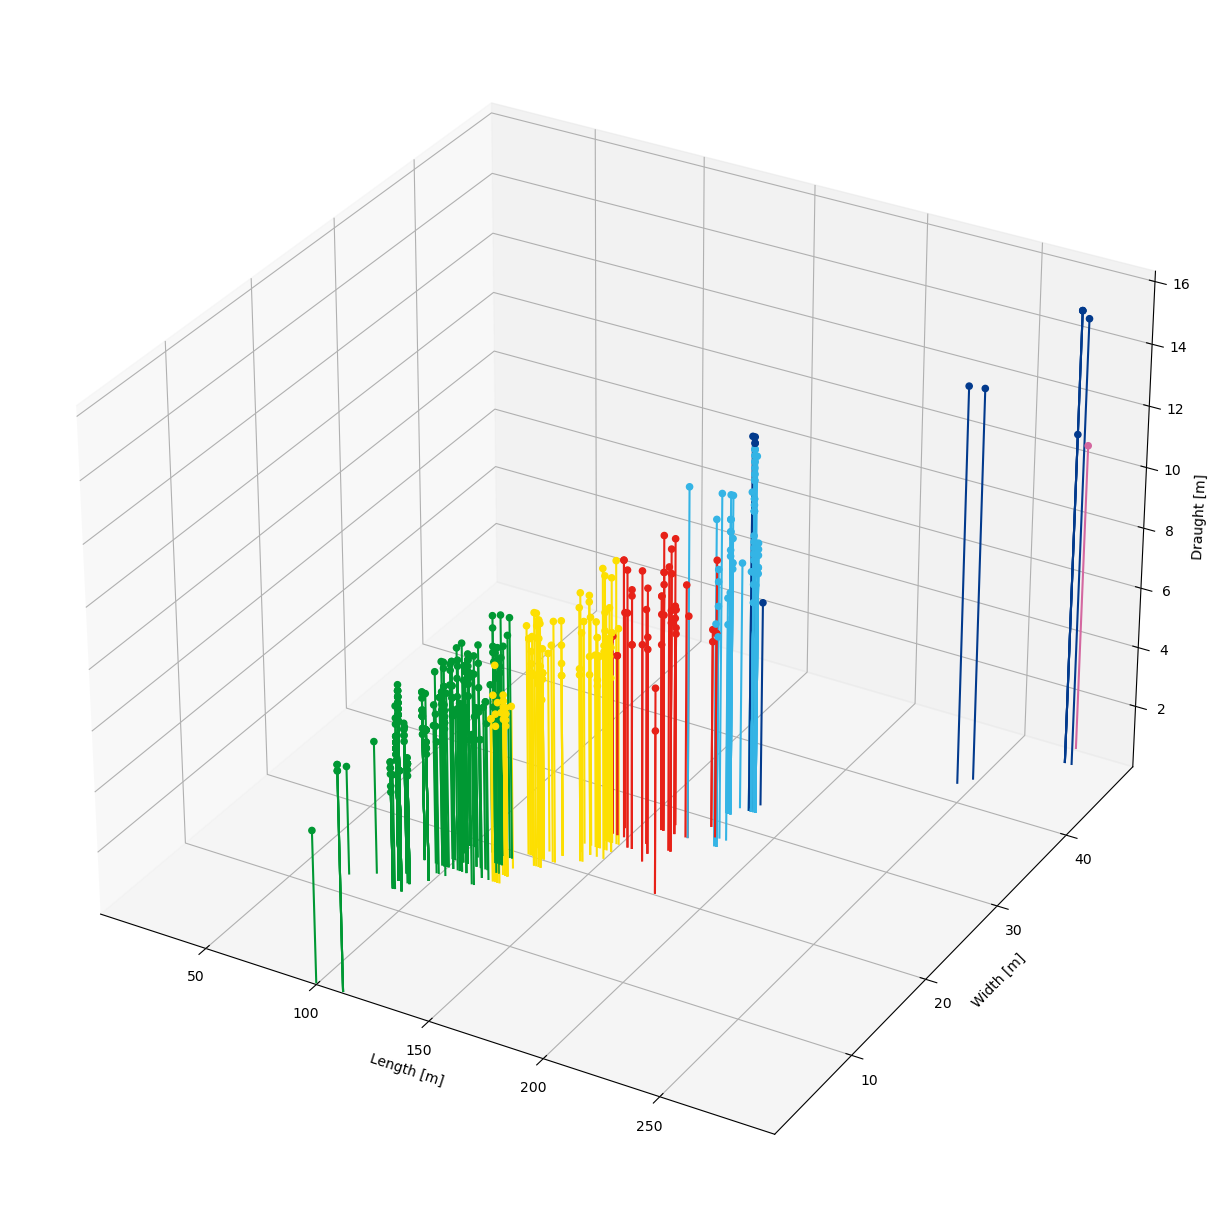

In [34]:
fig = plt.figure(figsize=(12, 12))
ax = Axes3D(fig)
L = origin_destination_matrix.length.to_numpy()
B = origin_destination_matrix.width.to_numpy()
T = origin_destination_matrix.draught.to_numpy()

ax.scatter(L,B,T,c=color,depthshade=False,zorder=0)
for l,b,t,c in zip(L,B,T,color):
    ax.plot([l,l],[b,b],[0,t],c=c,zorder=1)

ax.set_xlim(0,292.5)
ax.set_ylim(0,49)
ax.set_zlim(0,16)
ax.set_xlabel('Length [m]')
ax.set_ylabel('Width [m]')
ax.set_zlabel('Draught [m]')
ax.set_xbound(7.5)
ax.set_ybound(1)
ax.set_zbound(0.25)

plt.show()

In [35]:
def create_vessel(Vessel,env,name,origin,destination,next_destination,beam,length,draught,delta_draught,berthing_time,unloading_time,turning_time,arrival_time,terminal_of_call,berth_of_call,additional_waiting_time,bound='inbound',height=0.,ukc=0.,max_cross_current=0.):
    vessel_input = { "name":name,
                     "geometry":FG.nodes[origin]['geometry'],
                     "origin":origin,
                     "destination":destination,
                     "next_destination":next_destination,
                     "route":nx.dijkstra_path(FG,origin,destination[0]),
                     "env":env,
                     "type":'Tanker',
                     "B":beam,
                     "L":length,
                     "T": draught,
                     "H":height,
                     "t_berthing":berthing_time.total_seconds(),
                     "t_(un)loading":[time.total_seconds() for time in unloading_time],
                     "t_turning":[time.total_seconds() for time in turning_time],
                     "ukc":ukc,
                     "v":np.NaN,
                     "terminal_of_call": terminal_of_call,
                     "berth_of_call": berth_of_call,
                     "(un)loading": delta_draught,
                     "max_waiting_time":datetime.timedelta(days=10).total_seconds(),
                     "max_cross_current":max_cross_current,
                     "arrival_time":arrival_time,
                     "arrival_delay":arrival_time,
                     "priority": 0,
                     "additional_waiting_time": additional_waiting_time/np.timedelta64(1, 's'),
                     "bound":bound,
                     "priority":False}
    
    created_vessel = Vessel(**vessel_input)
    return created_vessel

In [36]:
origin_destination_matrix['arrival_time'] = origin_destination_matrix['arrival']+origin_destination_matrix['waiting_time_in_anchorage']
origin_destination_matrix['departure_time'] = origin_destination_matrix['arrival_time']+origin_destination_matrix['(un)loading time']
origin_destination_matrix['berth_of_call'] = [berth.split('Koole_')[1] for berth in origin_destination_matrix['berth_of_call']]
corrected_origin_destination_matrix = origin_destination_matrix.copy()
merge_locs = {}
for column in origin_destination_matrix.columns:
    origin_destination_matrix[column] = origin_destination_matrix[column].astype('object')
for name in list(dict.fromkeys(origin_destination_matrix.name)):
    df_ship = origin_destination_matrix[origin_destination_matrix.name == name]
    if len(df_ship) > 1:
        remove_indexes = []
        trip_merge = False
        for (_,prev_row),(_,next_row) in zip(df_ship.iloc[:-1].iterrows(),df_ship.iloc[1:].iterrows()):
            if next_row.arrival_time - prev_row.departure_time < pd.Timedelta(2,'h') and next_row.origin_node in ['8866999','8866859']:
                if not trip_merge:
                    merge_loc = prev_row.name
                    merge_trip_id = prev_row.trip_id
                    merge_locs[merge_trip_id] = []
                    trip_merge = True
                if trip_merge: 
                    remove_indexes.append(next_row.name)
                    merge_locs[merge_trip_id].append(next_row.trip_id)
                    for column in ['(un)loading','berth_of_call','(un)loading time','berth_node','destination_node','turning_time']:
                        origin_destination_matrix.at[merge_loc,column] = list(np.append(np.array(origin_destination_matrix.loc[merge_loc,column]),next_row[column]))   
            elif trip_merge:        
                trip_merge = False
        origin_destination_matrix = origin_destination_matrix.drop(remove_indexes)     

In [37]:
for column in ['(un)loading','berth_of_call','turning_time','(un)loading time','berth_node','destination_node']:
    values = []
    for value in origin_destination_matrix[column].to_numpy():
        if not isinstance(value,list):
            values.append([value])
        else:
            values.append(value)
    origin_destination_matrix[column] = values

In [38]:
for index in [12,109,156,175]:
    origin_destination_matrix.loc[index,'(un)loading'] = [np.max(origin_destination_matrix.loc[index]['(un)loading'])]
    origin_destination_matrix.loc[index,'berth_of_call'] = [origin_destination_matrix.loc[index]['berth_of_call'][0]]
    origin_destination_matrix.loc[index,'turning_time'] = [origin_destination_matrix.loc[index]['turning_time'][0]]
    origin_destination_matrix.loc[index,'(un)loading time'] = [np.sum(origin_destination_matrix.loc[index]['(un)loading time'])]
    origin_destination_matrix.loc[index,'destination_node'] = [origin_destination_matrix.loc[index]['destination_node'][-1]]

In [39]:
type(origin_destination_matrix.arrival_time.iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [40]:
origin_destination_matrix[origin_destination_matrix.trip_id == 'testschip-1635_1']

,name,trip_id,length,width,draught,(un)loading,berth_of_call,arrival,waiting_time_in_anchorage,turning_time,(un)loading time,origin_node,berth_node,destination_node,arrival_time,departure_time
156,testschip-1635,testschip-1635_1,112.0,0.0,7.2,[1.5999999046325684],[Buiten9],2019-05-08 05:50:42+00:00,0 days 10:03:09,[0 days 00:02:01],[1 days 05:22:07],8866969,"[8866859, 8866859]",[8866969],2019-05-08 15:53:51+00:00,2019-05-08 22:51:00+00:00


In [41]:
for index in origin_destination_matrix[origin_destination_matrix.origin_node == '8866859'].index:
    origin_destination_matrix.loc[index,'origin_node'] = '8866999'

In [42]:
# for loc,info in origin_destination_matrix.iterrows():
#     unloading_times = origin_destination_matrix.loc[loc,'(un)loading time']
#     unloading_times = [pd.Timedelta(2,'D') if laytime > pd.Timedelta(2,'D') else laytime for laytime in unloading_times] 
#     origin_destination_matrix.at[loc,'(un)loading time'] = unloading_times

In [43]:
def calculate_additional_waiting_time(trip_id1,trip_id2):
    arrival_time1 = origin_destination_matrix[origin_destination_matrix.trip_id == trip_id1].iloc[0].arrival
    arrival_time2 = origin_destination_matrix[origin_destination_matrix.trip_id == trip_id2].iloc[0].arrival
    delay = arrival_time2 - arrival_time1
    return {trip_id1:delay}

In [44]:
additional_waiting_times = {}
additional_waiting_times = {**calculate_additional_waiting_time('testschip-3417_0','testschip-2718_0'), #5.2 on 11.0
                            **calculate_additional_waiting_time('testschip-4407_0','testschip-4157_0'), #6.2 on 11.8
                            **calculate_additional_waiting_time('testschip-1186_0','testschip-3491_1'), #4.0 on 6.8
                            **calculate_additional_waiting_time('testschip-8014_0','testschip-1635_0'), #5.4 on 7.4
                            **calculate_additional_waiting_time('testschip-9416_0','testschip-4025_0'), #testschip-3144_1
                            **calculate_additional_waiting_time('testschip-3005_0','testschip-4815_1'),
                            **calculate_additional_waiting_time('testschip-12542_0','testschip-12705_0'),
                            **calculate_additional_waiting_time('testschip-2817_1','testschip-1290_1'), #testschip-12198_0
                            **calculate_additional_waiting_time('testschip-3762_1','testschip-1587_5'),
                            **calculate_additional_waiting_time('testschip-6532_1','testschip-5133_1'),
                            **calculate_additional_waiting_time('testschip-8702_0','testschip-14181_0'),
                            **calculate_additional_waiting_time('testschip-5981_0','testschip-4723_1'),
                            **calculate_additional_waiting_time('testschip-9057_0','testschip-14377_0'),
                            **calculate_additional_waiting_time('testschip-3688_0','testschip-4269_1'),
                            **calculate_additional_waiting_time('testschip-17119_0','testschip-1587_9'),
                            **calculate_additional_waiting_time('testschip-9057_1','testschip-5202_2'),
                            **calculate_additional_waiting_time('testschip-3491_2','testschip-6922_0'),
                            **calculate_additional_waiting_time('testschip-8702_1','testschip-1191_1'),
                            **calculate_additional_waiting_time('testschip-4683_0','testschip-18879_0'),
                            **calculate_additional_waiting_time('testschip-7523_0','testschip-4908_12'),
                            **calculate_additional_waiting_time('testschip-5108_1','testschip-5218_1'), #testschip-4723_2
                            **calculate_additional_waiting_time('testschip-4723_2','testschip-5218_1'),
                            **calculate_additional_waiting_time('testschip-4352_0','testschip-4723_3'),
                            **calculate_additional_waiting_time('testschip-1186_7','testschip-6052_3'),
                            **calculate_additional_waiting_time('testschip-4843_2','testschip-20371_0'),
                            **calculate_additional_waiting_time('testschip-2343_0','testschip-20933_0'), #estschip-9320_0
                            **calculate_additional_waiting_time('testschip-19943_0','testschip-5459_1'), #testschip-4810_1 #testschip-21204_0 #testschip-21279_0
                            **calculate_additional_waiting_time('testschip-4948_2','testschip-12657_1'),
                            **calculate_additional_waiting_time('testschip-9416_1','testschip-6409_2'),
                            **calculate_additional_waiting_time('testschip-6903_0','testschip-8786_0'), #testschip-6052_4
                            **calculate_additional_waiting_time('testschip-6782_2','testschip-18514_0'),
                            **calculate_additional_waiting_time('testschip-4955_2','testschip-12657_2'),
                            **calculate_additional_waiting_time('testschip-2528_1','testschip-9592_0')}
additional_waiting_times['testschip-5108_1']+=np.timedelta64(1,'s')

In [45]:
list_of_vessels = []
for loc,info in origin_destination_matrix.iterrows():
    Vessel = type('Vessel', (core.SimpyObject,core.Identifiable, port.HasPortAccess, port.HasAnchorage, port.HasTurningBasin, port.HasTerminal, core.Movable, core.Routeable, vessel_.VesselProperties, output.HasOutput, vessel_.ExtraMetadata), {}) #waterway.HasWaterway
    if info.origin_node in ['8868178','8866859','8866999']:
        bound = 'outbound'
    else:
        bound = 'inbound'
    if info.trip_id in additional_waiting_times.keys():
        additional_waiting_time = additional_waiting_times[info.trip_id]
    else:
        additional_waiting_time = np.timedelta64(0,'s')
    
    created_vessel = create_vessel(Vessel,
                                   env,
                                   name=info['name'],
                                   origin=info['origin_node'],
                                   destination=np.append([],info['berth_node']),
                                   next_destination=np.append([],info['destination_node']),
                                   beam=info['width'],
                                   length=info['length'],
                                   draught=info['draught'],
                                   delta_draught=np.append([],info['(un)loading']),
                                   berthing_time=pd.Timedelta(1,'s'),
                                   unloading_time=np.append([],info['(un)loading time']),
                                   turning_time= [pd.Timedelta(0,'s')], #np.append([],info['turning_time'][0]),
                                   arrival_time=info['arrival']+pd.Timedelta(1,'h'),
                                   terminal_of_call=np.array(['Koole' for i in range(len(list(info['berth_of_call'])))]),
                                   berth_of_call=np.array(info['berth_of_call']),
                                   additional_waiting_time = additional_waiting_time,
                                   bound=bound)
    list_of_vessels.append(created_vessel)

In [46]:
for index,vessel in enumerate(list_of_vessels):
    sim.add_vessels(vessel=vessel)

## Generate infrastructure

In [47]:
Koole_berths = pd.DataFrame({'MBL':[12.65,8.15,8.15,8.15,17,12.65,6.8,15.9,15.9],
                             'Length':[250,253.5,253.5,140,395,250,162,222,253]},
                            index=['Kade11','Kade_G','Kade_H','Binnen10','Buiten10','Buiten9','Binnen7','Buiten7','Buiten6'])
Koole_berths.index.name = 'Berth'

In [48]:
#(Change infrastructure capacities here)
turning_basin_1 = port.IsTurningBasin(env = env, name = 'Turning Basin 1', information = {'Length': 300})
anchorage_1 = port.IsAnchorage(env = env, name = 'Anchorage 1', capacity = 50)
terminal_1 = port.IsJettyTerminal(env=env,name = 'Koole terminal',type='jetty',information=Koole_berths)

## Assign infrastructure to graph

In [49]:
FG.nodes['anchorage']["Anchorage"] = [anchorage_1]
FG.edges['8866999', '8866859',0]["Terminal"] = {'Koole':terminal_1}
FG.nodes['8866999']["Turning Basin"] = [turning_basin_1]

# for node in FG.nodes:
#     number_of_edges = 0
#     for edge in FG.edges:
#         if node == edge[0]:
#             number_of_edges+=1
#     if number_of_edges != 2:
#         FG.nodes[node]["Junction"] = []

# junction_nodes = []
# for node in list(FG.nodes):
#     if 'Junction' in FG.nodes[node]:
#         junction_nodes.append(node)
        
# for node1 in junction_nodes:
#     names = []
#     sections = []
#     types = []
#     for node2 in junction_nodes:
#         if node1 == node2:
#             continue

#         route = nx.dijkstra_path(FG, node1, node2)
#         section = True
#         for node in route[1:-1]:
#             if 'Junction' in FG.nodes[node]:
#                 section = False
#                 break

#         if section:
#             sections.append([route[0],route[-1]])
    
#     FG.nodes[node1]["Junction"] = waterway.IsWaterwayJunction(env = env, 
#                                                               name = node1, 
#                                                               sections = sections, 
#                                                               detector_nodes = [node1,node2])

## Append the tidal restriction to the network

In [50]:
# #Conversion kn to m/s
knots = 0.51444

# #Restrictions as dictionaries
for node in env.FG.nodes:
    env.FG.nodes[node]['Info'] = {}
    env.FG.nodes[node]['Info']['Vertical tidal restriction'] = {}
env.FG.nodes['8861158']['Info']['Horizontal tidal restriction'] = {}

In [51]:
network_properties = tidal_window_constructor.NetworkProperties()

### Vertical tidal window

In [52]:
#According to Port of Rotterdam Policy (Change here the ukc policy)
ukc_p = []
ukc_s = []
fwa = []
        
for index,node in enumerate(env.FG.nodes):
    if node in ['8866969','8866305','8864266','8862925','8864465','S14716_B','S14716_A','8860845']:
        ukc_s.append(0.)
        ukc_p.append(0.1)
        fwa.append(0.01)
    elif node in ['8867547','8867980','8866999']:
        ukc_s.append(1.0)
        ukc_p.append(0.0)
        fwa.append(0.025)
    elif node in ['8866859']:
        ukc_s.append(0.5)
        ukc_p.append(0.0)
        fwa.append(0.0)
    elif node in ['anchorage']:
        ukc_s.append(0.0)
        ukc_p.append(0.0)
        fwa.append(0.0)
    else:
        ukc_s.append(0.0)
        ukc_p.append(0.1)
        fwa.append(0.025)
        
for index,node in enumerate(env.FG.nodes):
    vertical_tidal_window_inputs = []

    #Inbound_Vessels_Condition
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.min_ge_Draught: 0},
                                                                           'x',rule_constructor.vessel_direction.inbound.value)

    window_specification = tidal_window_constructor.vertical_tidal_window_specifications(ukc_s = ukc_s[index],
                                                                                         ukc_p = ukc_p[index],
                                                                                         fwa = fwa[index],)
    
    vertical_tidal_window_inputs.append(tidal_window_constructor.vertical_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                             window_specifications = window_specification))

    #Outbound_Vessels_Condition
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.min_ge_Draught: 0},
                                                                           'x',rule_constructor.vessel_direction.outbound.value)

    window_specification = tidal_window_constructor.vertical_tidal_window_specifications(ukc_s = ukc_s[index],
                                                                                         ukc_p = ukc_p[index],
                                                                                         fwa = fwa[index],)

    vertical_tidal_window_inputs.append(tidal_window_constructor.vertical_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                             window_specifications = window_specification))

    network_properties.append_vertical_tidal_restriction_to_network(FG,node,vertical_tidal_window_inputs)

### Horizontal tidal window

In [53]:
#Port of Rotterdam Policy 3rd Petroleum Harbour
previous_nodes = ['8861716','8861674']
node = '8861158'
next_node = '8867547'
knots = 0.5144444
horizontal_tidal_window_inputs = []
scheurkade_data = hydrodynamic_data.sel({'STATION':'Scheurkade'})
scheurkade_data['TIME'] = scheurkade_data.TIME.values - np.timedelta64(20,'m')

for previous_node in previous_nodes:
    #Inbound_Vessels_Condition1
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.min_ge_Length: 180,
                                                                           rule_constructor.vessel_characteristics.min_ge_Draught: 11.0, #11.0
                                                                           rule_constructor.vessel_characteristics.max_lt_Draught: 14.3},
                                                                           '(x and x and x)',rule_constructor.vessel_direction.inbound.value)

    window_specification = tidal_window_constructor.horizontal_tidal_window_specifications(tidal_window_constructor.horizontal_tidal_window_method.maximum.value,
                                                                                           {tidal_window_constructor.tidal_period.Flood.value: 2*knots,tidal_window_constructor.tidal_period.Ebb.value: 2*knots})


    horizontal_tidal_window_inputs.append(tidal_window_constructor.horizontal_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                                 window_specifications = window_specification,
                                                                                                 condition = {'Origin': previous_node, 'Destination': next_node},
                                                                                                 data = scheurkade_data))
    #Inbound_Vessels_Condition2
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.min_ge_Draught: 14.3},
                                                  'x',rule_constructor.vessel_direction.inbound.value)

    window_specification = tidal_window_constructor.horizontal_tidal_window_specifications(tidal_window_constructor.horizontal_tidal_window_method.point_based.value,
                                                                                           {tidal_window_constructor.tidal_period.Flood.value: [1.3*0.5*knots,0.7*0.5*knots],tidal_window_constructor.tidal_period.Ebb.value:tidal_window_constructor.accessibility.inaccessible.value})

    horizontal_tidal_window_inputs.append(tidal_window_constructor.horizontal_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                                 window_specifications = window_specification,
                                                                                                 condition = {'Origin': previous_node, 'Destination': next_node},
                                                                                                 data = scheurkade_data))

    #Outbound_Vessels_Condition1  
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.min_ge_Length: 200,
                                                                           rule_constructor.vessel_characteristics.min_ge_Draught: 12.0, #12.0
                                                                           rule_constructor.vessel_characteristics.max_lt_Draught: 14.3},
                                                                           '(x and x and x)',rule_constructor.vessel_direction.outbound.value)

    window_specification = tidal_window_constructor.horizontal_tidal_window_specifications(tidal_window_constructor.horizontal_tidal_window_method.maximum.value,
                                                                                           {tidal_window_constructor.tidal_period.Flood.value: 2*knots,tidal_window_constructor.tidal_period.Ebb.value:tidal_window_constructor.accessibility.accessible.value})


    horizontal_tidal_window_inputs.append(tidal_window_constructor.horizontal_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                                 window_specifications = window_specification,
                                                                                                 condition = {'Origin': next_node, 'Destination': previous_node},
                                                                                                 data = scheurkade_data))

    #Outbound_Vessels_Condition2
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.min_ge_Draught: 14.3}, #14.3
                                                  'x',rule_constructor.vessel_direction.outbound.value)

    window_specification = tidal_window_constructor.horizontal_tidal_window_specifications(tidal_window_constructor.horizontal_tidal_window_method.point_based.value,
                                                                                           {tidal_window_constructor.tidal_period.Flood.value: [1.3*0.5*knots,0.7*0.5*knots],tidal_window_constructor.tidal_period.Ebb.value:tidal_window_constructor.accessibility.inaccessible.value})

    horizontal_tidal_window_inputs.append(tidal_window_constructor.horizontal_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                                 window_specifications = window_specification,
                                                                                                 condition = {'Origin': next_node, 'Destination': previous_node},
                                                                                                 data = scheurkade_data))

network_properties.append_horizontal_tidal_restriction_to_network(FG,node,horizontal_tidal_window_inputs)

## Initiation of the simulation

In [54]:
t1 = timpie.time()
sim.run()
t2 = timpie.time()
print('total simulation time:', t2-t1)

total simulation time: 447.2708466053009


In [55]:
terminal = FG.edges['8866859','8866999',0]['Terminal']['Koole']

In [56]:
for item in terminal.resource.items:
    print(item.name)

Binnen7
Buiten7
Buiten6
Binnen10
Kade_G
Kade_H
Buiten10
Buiten9


In [57]:
item

## Output

In [58]:
vessels = sim.environment.vessels #extract vessels (entitie) from environment. It collects info while it moves through the network. That info is stored in the log file. The log file has 
env = sim.environment #extract the environment itself

In [59]:
df = pd.DataFrame.from_dict(vessels[-299].log) #creates a data frame with all the info of vessels[0].
df.head(n=60)

,Time,Location,Action,Status
0,2019-05-23 12:44:59.000000,POINT (4.290443348198153 51.88584086460477),Sailing from node 8865217 to node 8860596 start,"{'origin': '8865217', 'destination': '8866859'..."
1,2019-05-23 12:55:54.054935,POINT (4.303309561063084 51.88842312448143),Sailing from node 8865217 to node 8860596 stop,"{'origin': '8865217', 'destination': '8866859'..."
2,2019-05-23 12:55:54.054935,POINT (4.303309561063084 51.88842312448143),Sailing from node 8860596 to node 8867980 start,"{'origin': '8865217', 'destination': '8866859'..."
3,2019-05-23 12:59:41.289113,POINT (4.30901781752353 51.8895642784668),Sailing from node 8860596 to node 8867980 stop,"{'origin': '8865217', 'destination': '8866859'..."
4,2019-05-23 12:59:41.289113,POINT (4.30901781752353 51.8895642784668),Sailing from node 8867980 to node 8866999 start,"{'origin': '8865217', 'destination': '8866859'..."
5,2019-05-23 13:08:17.245450,POINT (4.3079461632343 51.880438540609305),Sailing from node 8867980 to node 8866999 stop,"{'origin': '8865217', 'destination': '8866859'..."
6,2019-05-23 13:08:17.245450,POINT (4.3079461632343 51.880438540609305),Turning start,"{'origin': '8865217', 'destination': '8866859'..."
7,2019-05-23 13:08:17.245450,POINT (4.3079461632343 51.880438540609305),Turning stop,"{'origin': '8865217', 'destination': '8866859'..."
8,2019-05-23 13:08:17.245450,POINT (4.31255463164922 51.8710072122171),Berthing start,"{'origin': '8865217', 'destination': '8866859'..."
9,2019-05-23 13:08:18.245450,POINT (4.31255463164922 51.8710072122171),Berthing stop,"{'origin': '8865217', 'destination': '8866859'..."


### Anchorage

In [60]:
df = pd.DataFrame.from_dict(FG.nodes['anchorage']['Anchorage'][0].log)
df

,Time,Location,Action,Status
0,2019-01-05 17:03:49.000000,POINT (4.04470684375659 51.9905399816771),Vessel arrival,"{'vessel_information': {'origin': '8866969', '..."
1,2019-01-10 01:01:32.000000,POINT (4.04470684375659 51.9905399816771),Vessel arrival,"{'vessel_information': {'origin': '8866969', '..."
2,2019-01-10 01:01:32.000000,POINT (4.04470684375659 51.9905399816771),Vessel departure,"{'vessel_information': {'origin': '8866969', '..."
3,2019-01-10 02:21:30.000000,POINT (4.04470684375659 51.9905399816771),Vessel arrival,"{'vessel_information': {'origin': '8866969', '..."
4,2019-01-12 08:06:12.000000,POINT (4.04470684375659 51.9905399816771),Vessel arrival,"{'vessel_information': {'origin': '8866969', '..."
5,2019-01-12 18:32:23.000000,POINT (4.04470684375659 51.9905399816771),Vessel arrival,"{'vessel_information': {'origin': '8866969', '..."
6,2019-01-13 20:47:39.000000,POINT (4.04470684375659 51.9905399816771),Vessel arrival,"{'vessel_information': {'origin': '8866969', '..."
7,2019-01-14 18:15:30.000000,POINT (4.04470684375659 51.9905399816771),Vessel departure,"{'vessel_information': {'origin': '8866969', '..."
8,2019-01-16 01:03:25.359823,POINT (4.04470684375659 51.9905399816771),Vessel departure,"{'vessel_information': {'origin': '8866969', '..."
9,2019-02-12 12:42:56.000000,POINT (4.04470684375659 51.9905399816771),Vessel arrival,"{'vessel_information': {'origin': '8866969', '..."


### Turning basin

In [61]:
df = pd.DataFrame.from_dict(FG.nodes['8866999']['Turning Basin'][0].log)
df

,Time,Location,Action,Status
0,2019-01-01 13:41:28.359823,POINT (4.3079461632343 51.880438540609305),Turning start,"{'vessel_information': {'origin': '8866969', '..."
1,2019-01-01 13:41:28.359823,POINT (4.3079461632343 51.880438540609305),Turning stop,"{'vessel_information': {'origin': '8866969', '..."
2,2019-01-01 22:58:10.359823,POINT (4.3079461632343 51.880438540609305),Vessel Passing,"{'vessel_information': {'origin': '8866969', '..."
3,2019-01-02 10:13:47.359823,POINT (4.3079461632343 51.880438540609305),Turning start,"{'vessel_information': {'origin': '8866969', '..."
4,2019-01-02 10:13:47.359823,POINT (4.3079461632343 51.880438540609305),Turning stop,"{'vessel_information': {'origin': '8866969', '..."
...,...,...,...,...
1428,2019-12-30 20:14:25.870028,POINT (4.3079461632343 51.880438540609305),Vessel Passing,"{'vessel_information': {'origin': '8865217', '..."
1429,2019-12-31 02:03:13.245450,POINT (4.3079461632343 51.880438540609305),Vessel Passing,"{'vessel_information': {'origin': '8865217', '..."
1430,2019-12-31 08:35:43.931368,POINT (4.3079461632343 51.880438540609305),Vessel Passing,"{'vessel_information': {'origin': '8865217', '..."
1431,2019-12-31 11:57:29.829514,POINT (4.3079461632343 51.880438540609305),Turning start,"{'vessel_information': {'origin': '8860727', '..."


### Terminal

In [62]:
terminal = FG.edges['8866859','8866999',0]['Terminal']['Koole']
df = pd.DataFrame.from_dict(terminal.log) #creates a data frame with all the info of vessels[0].
df.head(n=60)

,Time,Location,Action,Status
0,2019-01-01 13:41:28.359823,POINT (4.3079461632343 51.880438540609305),Arrival of vessel,"{'vessel_information': {'origin': '8866969', '..."
1,2019-01-01 22:58:10.359823,POINT (4.3079461632343 51.880438540609305),Departure of vessel,"{'vessel_information': {'origin': '8866969', '..."
2,2019-01-02 10:13:47.359823,POINT (4.3079461632343 51.880438540609305),Arrival of vessel,"{'vessel_information': {'origin': '8866969', '..."
3,2019-01-02 17:01:23.359823,POINT (4.3079461632343 51.880438540609305),Departure of vessel,"{'vessel_information': {'origin': '8866969', '..."
4,2019-01-03 07:22:49.359823,POINT (4.3079461632343 51.880438540609305),Arrival of vessel,"{'vessel_information': {'origin': '8866969', '..."
5,2019-01-04 02:07:40.359823,POINT (4.3079461632343 51.880438540609305),Departure of vessel,"{'vessel_information': {'origin': '8866969', '..."
6,2019-01-04 13:58:57.359823,POINT (4.3079461632343 51.880438540609305),Arrival of vessel,"{'vessel_information': {'origin': '8866969', '..."
7,2019-01-05 15:29:02.359823,POINT (4.3079461632343 51.880438540609305),Departure of vessel,"{'vessel_information': {'origin': '8866969', '..."
8,2019-01-06 02:44:47.000000,POINT (4.3079461632343 51.880438540609305),Arrival of vessel,"{'vessel_information': {'origin': '8866999', '..."
9,2019-01-07 03:30:35.359823,POINT (4.3079461632343 51.880438540609305),Arrival of vessel,"{'vessel_information': {'origin': '8866969', '..."


In [63]:
terminal.output['Buiten10']

{'vessel_information': {'origin': '8863525',
  'destination': '8866859',
  'route': ['8863525',
   '8864952',
   '8866635',
   '8868177',
   '8862214',
   '8866780',
   '8864465',
   'S14716_B',
   'S14716_A',
   '8860845',
   '8861674',
   '8861158',
   '8867547',
   '8867980',
   '8866999',
   '8866859'],
  'bound': 'inbound',
  'anchorage': '',
  'turning_basin': '',
  'terminal': 'Koole',
  'berth': 'Buiten10',
  'length': 102.0,
  'beam': 19.0,
  'draught': 5.800000190734863,
  'sailing_distance': 31151.90536759668,
  'sailing_time': 6911.870028206833,
  'waiting_times_in_anchorages': [],
  'waiting_times_at_terminals': [[{'Priority': Timedelta('0 days 00:00:00'),
     'Availability': Timedelta('0 days 00:00:00'),
     'Tidal window': Timedelta('0 days 00:00:00')}]],
  'turning_times': [0.0],
  '(un)loading_times': [120575.0],
  'current_node': '8866999',
  'next_node': '8866859',
  'speed': 2.0132698225168015,
  'heading': 6.715630470798041,
  'water_level': -0.64497846,
  'MBL':

### Vessel

In [64]:
output_df = pd.DataFrame(columns=['Shipname','Length','Beam','Trip_number','Origin','Destination','Routes','Anchorage_area',
                                  'Waiting_time_in_anchorage','Waiting_time_at_terminal','Turning_basin','Turning_time',
                                  'Terminal_of_call','Berth_of_call','(Un)loading_time','Total_sailing_time','Times',
                                  'Actions','Location','Nodes','Sailing_distance','Speed','Heading','Draught','MBL',
                                  'Net_UKC','Gross_UKC','Ship_related_factors','Water_level','Limiting_current_velocity'])
for vessel in vessels:
    df = pd.DataFrame.from_dict(vessel.log)
    if vessel.output['sailed_routes']:
        output_df = pd.concat([output_df,pd.DataFrame(data=[[vessel.name, #'Shipname'   
                                                             vessel.L, #'Length'
                                                             vessel.B, #'Beam'
                                                             0, #'Trip_number'
                                                             vessel.output['sailed_routes'][0][0], #'Origin'
                                                             vessel.output['sailed_routes'][-1][-1], #'Destination'
                                                             vessel.output['sailed_routes'], #'Routes' 
                                                             vessel.output['visited_anchorages'], #'Anchorage_area'
                                                             vessel.output['waiting_times_in_anchorages'], #'Waiting_time_in_anchorage'
                                                             vessel.output['waiting_times_at_terminals'], #'Waiting_time_in_anchorage'
                                                             vessel.output['visited_turning_basins'], #'Turning_basin'
                                                             vessel.output['turning_times'], #'Turning_time'
                                                             vessel.output['visited_terminals'], #'Terminal_of_call'
                                                             vessel.output['visited_berths'], #'Berth_of_call'
                                                             vessel.output['(un)loading_times'], #'(Un)loading_time'
                                                             np.array([status['sailing_time'] for status in df.Status.to_numpy()]).sum(), #'Total_sailing_time'
                                                             df.Time.to_numpy(), #'Times'
                                                             df.Action.to_numpy(), #'Actions'
                                                             df.Location.to_numpy(), #'Location'
                                                             np.array([status['current_node'] for status in df.Status.to_numpy()]), #'Nodes'
                                                             np.array([status['sailing_distance'] for status in df.Status]), #'Sailing_distance'
                                                             np.array([status['speed'] for status in df.Status.to_numpy()]), #'Speed'
                                                             np.array([status['heading'] for status in df.Status.to_numpy()]), #'Heading'
                                                             np.array([status['draught'] for status in df.Status.to_numpy()]), #'Draught'
                                                             np.array([status['MBL'] for status in df.Status.to_numpy()]), #'MBL'
                                                             np.array([status['net_ukc'] for status in df.Status.to_numpy()]), #'Net_UKC'
                                                             np.array([status['gross_ukc'] for status in df.Status.to_numpy()]), #'Gross_UKC'
                                                             np.array([status['ship_related_ukc_factors'] for status in df.Status.to_numpy()]), #'Ship_related_factors'
                                                             np.array([status['water_level'] for status in df.Status.to_numpy()]), #'Water_level'
                                                             np.array([status['limiting current velocity'] for status in df.Status.to_numpy()])]], #'Limiting_current_velocity'
                                                      columns=output_df.columns)])

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_20952\1530761757.py:18: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_20952\1530761757.py:18: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



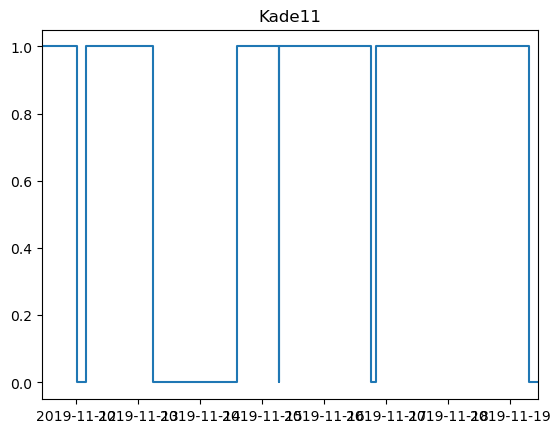

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_20952\1530761757.py:18: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_20952\1530761757.py:18: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



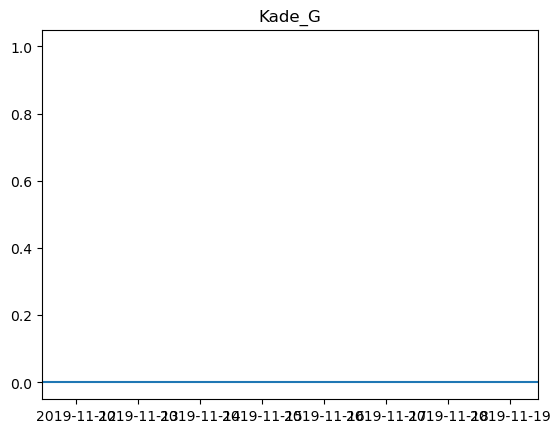

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_20952\1530761757.py:18: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_20952\1530761757.py:18: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



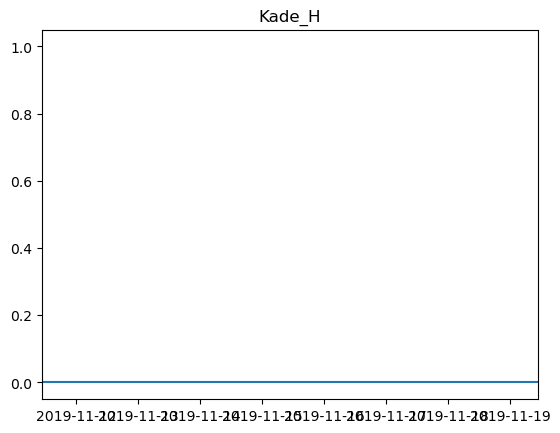

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_20952\1530761757.py:18: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_20952\1530761757.py:18: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



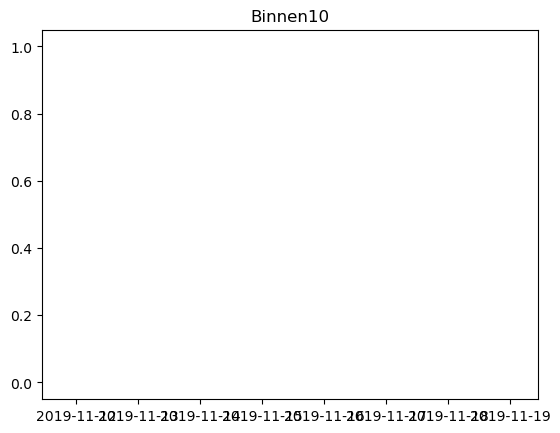

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_20952\1530761757.py:18: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_20952\1530761757.py:18: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



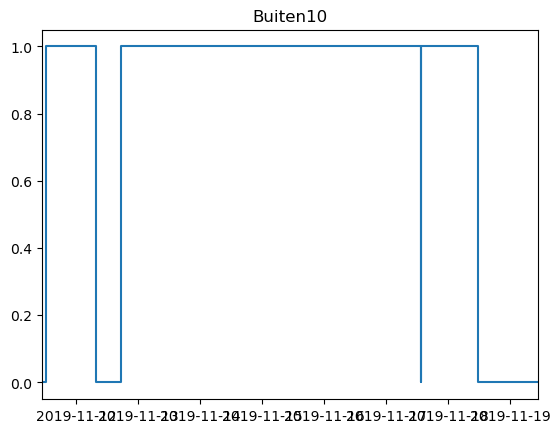

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_20952\1530761757.py:18: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_20952\1530761757.py:18: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



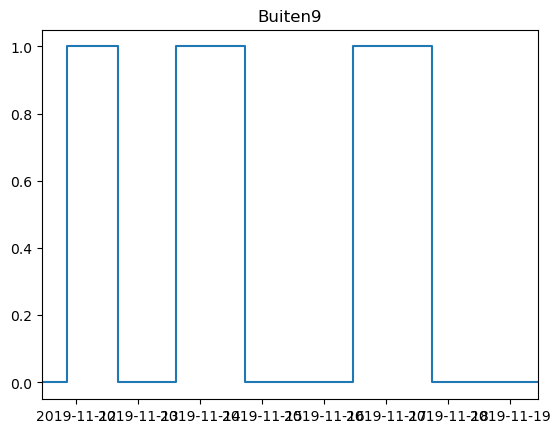

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_20952\1530761757.py:18: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_20952\1530761757.py:18: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



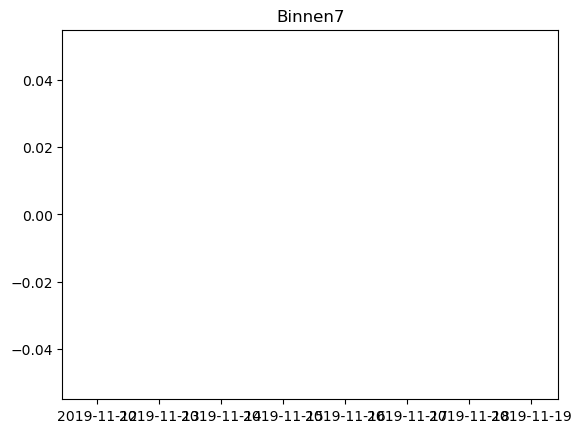

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_20952\1530761757.py:18: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_20952\1530761757.py:18: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



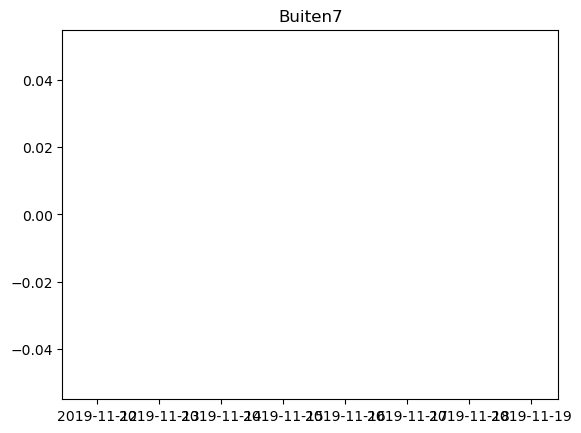

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_20952\1530761757.py:18: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_20952\1530761757.py:18: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



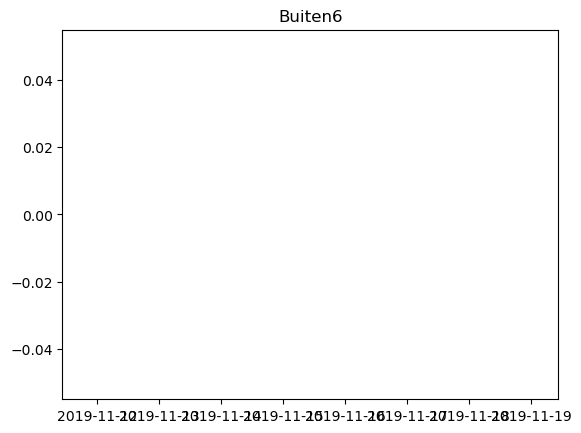

In [65]:
terminal = FG.edges['8866859','8866999',0]['Terminal']['Koole']
df = pd.DataFrame.from_dict(terminal.log) #creates a data frame with all the info of vessels[0].
for berth in Koole_berths.index:
    times = []
    occupied = []
    for loc,info in df.iterrows():
        if info.Action == 'Departure of vessel' and info.Status['vessel_information']['berth'] == berth:
            times.append(datetime.datetime.fromtimestamp(info.Status['vessel_arrival']))
            occupied.append(0)
            times.append(datetime.datetime.fromtimestamp(info.Status['vessel_arrival']))
            occupied.append(1)
            times.append(datetime.datetime.fromtimestamp(info.Status['vessel_departure']))
            occupied.append(1)
            times.append(datetime.datetime.fromtimestamp(info.Status['vessel_departure']))
            occupied.append(0)
    plt.plot(times,occupied)
    plt.title(berth)
    plt.xlim([np.datetime64('2019-11-11 10:35:37+00:00'),np.datetime64('2019-11-11 10:35:37+00:00')+np.timedelta64(8,'D')])
    plt.show()

In [66]:
len(output_df)

481

In [67]:
output_df = output_df.reset_index(drop=True)
output_df['Trip_id'] = output_df['Shipname']+'_0'

In [68]:
for name in list(dict.fromkeys(output_df.Shipname)):
    in_df = origin_destination_matrix[origin_destination_matrix.name == name]
    out_df = output_df[output_df.Shipname == name]
    for trip_id,loc in enumerate(out_df.index):
        output_df.loc[loc,'Trip_id'] = in_df.iloc[trip_id].trip_id

In [69]:
waiting_time_comparison = {}
for loc,trip_id in enumerate(output_df.Trip_id):
    modelled_waiting_time_in_anchorage = output_df.loc[loc].Waiting_time_in_anchorage
    modelled_waiting_time_at_terminal = output_df.loc[loc].Waiting_time_at_terminal

In [70]:
waiting_time_comparison = {}
for loc,trip_id in enumerate(output_df.Trip_id):
    modelled_waiting_time_in_anchorage = output_df.loc[loc].Waiting_time_in_anchorage
    modelled_waiting_time_at_terminal = output_df.loc[loc].Waiting_time_at_terminal
    if modelled_waiting_time_in_anchorage:
        total_waiting_time = np.sum(list(modelled_waiting_time_in_anchorage[0].values()))
        waiting_for_available_terminal = modelled_waiting_time_in_anchorage[0]['Availability']
        waiting_for_tidal_window = modelled_waiting_time_in_anchorage[0]['Tidal window']
        waiting_due_to_priority = modelled_waiting_time_in_anchorage[0]['Priority']
    elif modelled_waiting_time_at_terminal:
        total_waiting_time = np.sum(list(modelled_waiting_time_at_terminal[0][0].values()))
        waiting_for_available_terminal = modelled_waiting_time_at_terminal[0][0]['Availability']
        waiting_for_tidal_window = modelled_waiting_time_at_terminal[0][0]['Tidal window']
        waiting_due_to_priority =  modelled_waiting_time_at_terminal[0][0]['Priority']
    else:
        total_waiting_time = pd.Timedelta(0,'s')
        waiting_due_to_priority = pd.Timedelta(0,'s')
        waiting_for_tidal_window = pd.Timedelta(0,'s')
        waiting_for_available_terminal = pd.Timedelta(0,'s')
    if modelled_waiting_time_at_terminal:
        total_waiting_time += np.sum(list(modelled_waiting_time_at_terminal[0][-1].values()))
        outbound_waiting_for_available_terminal = modelled_waiting_time_at_terminal[0][-1]['Availability']
        outbound_waiting_for_tidal_window = modelled_waiting_time_at_terminal[0][-1]['Tidal window']
        outbound_waiting_due_to_priority =  modelled_waiting_time_at_terminal[0][-1]['Priority']
    else:
        outbound_waiting_due_to_priority = pd.Timedelta(0,'s')
        outbound_waiting_for_tidal_window = pd.Timedelta(0,'s')
        outbound_waiting_for_available_terminal = pd.Timedelta(0,'s')
        
    
    waiting_time_comparison[trip_id] = [waiting_for_tidal_window,
                                        waiting_for_available_terminal,
                                        waiting_due_to_priority,
                                        outbound_waiting_due_to_priority,
                                        outbound_waiting_for_available_terminal,
                                        outbound_waiting_for_tidal_window,
                                        total_waiting_time,
                                        origin_destination_matrix[origin_destination_matrix.trip_id == trip_id].waiting_time_in_anchorage.to_numpy()[0]]

In [71]:
comparison_df = pd.DataFrame.from_dict(waiting_time_comparison,orient='index',columns=['Waiting_for_tidal_window_inbound',
                                                                                       'Waiting_for_available_berth_inbound',
                                                                                       'Waiting_due_to_priority_inbound',
                                                                                       'Waiting_due_to_priority_outbound',
                                                                                       'Waiting_for_available_berth_outbound',
                                                                                       'Waiting_for_tidal_window_outbound',
                                                                                       'Modelled_total_waiting_time',
                                                                                       'Observed_total_waiting_time'])
for index in comparison_df[pd.isnull(comparison_df['Observed_total_waiting_time'].to_numpy())].index:
    comparison_df.loc[index,'Observed_total_waiting_time'] = np.timedelta64(0,'s')

In [ ]:
turnaround_time = []
for vessel in vessels:
    turnaround_time.append(vessel.log['Time'][-1]-vessel.log['Time'][0])

In [ ]:
with open('test_model_outcome.pickle','wb') as handle:
    pickle.dump(comparison_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('test_model_outcome.pickle','rb') as handle: #full_model
    full_model_comparison_df = pickle.load(handle)

In [ ]:
with open('model_without_turning.pickle','rb') as handle: #model_no_priority_no_tidal_window
    model_without_turning = pickle.load(handle)

In [ ]:
with open('model_outcome_no_priority_no_tidal_window.pickle','rb') as handle: #model_no_priority_no_tidal_window
    model_no_priority_no_tidal_window_comparison_df = pickle.load(handle)

In [ ]:
with open('model_outcome.pickle','rb') as handle: #full_model
    full_model_comparison_df = pickle.load(handle)

In [ ]:
with open('model_with_shallowing.pickle','rb') as handle: #model_no_priority_no_tidal_window
    model_with_shallowing = pickle.load(handle)

In [ ]:
with open('model_without_long_laytimes.pickle','rb') as handle: #model_no_priority_no_tidal_window
    model_without_long_laytimes = pickle.load(handle)

In [ ]:
with open('model_outcome_no_priority.pickle','rb') as handle: #model_no_priority
    model_no_priority_comparison_df = pickle.load(handle)

In [ ]:
with open('model_outcome_no_tidal_window.pickle','rb') as handle: #model_no_tidal_window
    model_no_tidal_window_comparison_df = pickle.load(handle)

In [ ]:
ship_types = {}
for row,trip_info in origin_destination_matrix.iterrows():
    for ship_type,ship_dimensions in type_dataframe.iterrows():
        if trip_info.length <= ship_dimensions.Length and trip_info.width <= ship_dimensions.Width and trip_info.draught <= ship_dimensions.Draught:
            ship_types[trip_info.trip_id] = ship_type
            break
shiptype_df = pd.DataFrame.from_dict(ship_types, orient='index', columns=['Shiptype'])

In [ ]:
np.sum(full_model_comparison_df.Observed_total_waiting_time)

In [ ]:
np.sum(full_model_comparison_df.Waiting_for_tidal_window_inbound)

In [ ]:
np.sum(full_model_comparison_df.Modelled_total_waiting_time)

In [ ]:
np.sum(full_model_comparison_df.Modelled_total_waiting_time)

In [ ]:
(109+22/24)/107

In [ ]:
data = full_model_comparison_df.Observed_total_waiting_time-full_model_comparison_df.Modelled_total_waiting_time
time_mask = (data > pd.Timedelta(0,'H'))
name_mask = (data.index.isin(shiptype_df[~shiptype_df.Shiptype.isin(['Panamax','New Panamax','Suezmax'])].index))
mask = time_mask#&name_mask

In [ ]:
data[mask]

In [ ]:
plt.hist(data[mask].to_numpy()/pd.Timedelta(1,'s')/3600,bins=np.arange(0,96,6),edgecolor='k');

In [ ]:
p = 7.8
np.percentile(data[mask],p)/np.timedelta64(1,'s')/3600,100-p

In [ ]:
np.percentile(data[mask],50)/np.timedelta64(1,'s')/3600

In [ ]:
mask = data < pd.Timedelta(3,'h')
len(full_model_comparison_df[mask])/len(full_model_comparison_df)

In [ ]:
ship_types = {}
for row,trip_info in origin_destination_matrix.iterrows():
    for ship_type,ship_dimensions in type_dataframe.iterrows():
        if trip_info.length <= ship_dimensions.Length and trip_info.width <= ship_dimensions.Width and trip_info.draught <= ship_dimensions.Draught:
            ship_types[trip_info.trip_id] = ship_type
            break

In [ ]:
vessels_with_tidal_window = {}
for row,trip_info in origin_destination_matrix.iterrows():
    for ship_type,ship_dimensions in type_dataframe.iterrows():
        if trip_info.length >= 180 and trip_info.draught <= 11.0 and trip_info.draught < 14.3:
            vessels_with_tidal_window[trip_info.trip_id] = 'Critical current'
        elif trip_info.draught >= 14.3:
            vessels_with_tidal_window[trip_info.trip_id] = 'Point based'
            break

In [ ]:
tidal_window_df = pd.DataFrame.from_dict(vessels_with_tidal_window, orient='index', columns=['Tidal window type'])

In [ ]:
mask = full_model_comparison_df[full_model_comparison_df.index.isin(tidal_window_df.index)].Waiting_for_tidal_window_inbound>pd.Timedelta(0,'s')

In [ ]:
names = full_model_comparison_df[full_model_comparison_df.index.isin(tidal_window_df.index)][mask].Waiting_for_tidal_window_inbound.index

In [ ]:
shiptype_df = pd.DataFrame.from_dict(ship_types, orient='index', columns=['Shiptype'])

In [ ]:
contribution_tidal_window = np.sum(full_model_comparison_df.Waiting_for_tidal_window_inbound)/np.sum(full_model_comparison_df.Modelled_total_waiting_time)
contribution_tidal_window

In [ ]:
nx.dijkstra_path(FG,'8866969','8866999')

In [ ]:
def calculate_absolute_waiting_times(df):
    total_waiting_time = np.sum(df.Modelled_total_waiting_time)
    average_waiting_time = np.mean(df[df.Modelled_total_waiting_time > pd.Timedelta(0,'s')].Modelled_total_waiting_time)
    return total_waiting_time,average_waiting_time

In [ ]:
unresolved_df = full_model_comparison_df.Observed_total_waiting_time-full_model_comparison_df.Modelled_total_waiting_time
np.sum(unresolved_df[unresolved_df > pd.Timedelta(6,'h')])

In [ ]:
def calculate_waiting_time_percentages(full_model_comparison_df,model_no_priority_comparison_df,model_no_tidal_window_comparison_df,cascading=False,observed=True,direct=True):
    if observed:  
        relative_df = full_model_comparison_df.Observed_total_waiting_time
    else:
        relative_df = full_model_comparison_df.Modelled_total_waiting_time
    
    if direct:
        difference_df = (relative_df-full_model_comparison_df.Modelled_total_waiting_time)
        unresolved_waiting_time = np.sum(difference_df[difference_df >= np.timedelta64(0,'s')])/(np.sum(relative_df)+pd.Timedelta(1,'s'))
    else:
        unresolved_waiting_time = 1-np.sum(full_model_comparison_df.Modelled_total_waiting_time)/np.sum(relative_df)
    unresolved_df = relative_df-full_model_comparison_df.Modelled_total_waiting_time
    long_term_unresolved = np.sum(unresolved_df[unresolved_df > pd.Timedelta(12,'h')])/(np.sum(unresolved_df[unresolved_df > pd.Timedelta(0,'h')])+pd.Timedelta(1,'s'))
    short_term_unresolved = 1-long_term_unresolved
    resolved_waiting_time = 1-unresolved_waiting_time
    waiting_time_availability = np.sum(full_model_comparison_df.Waiting_for_available_berth_inbound)/(np.sum(full_model_comparison_df.Modelled_total_waiting_time)+np.timedelta64(1,'s'))
    waiting_time_priority = np.sum(full_model_comparison_df.Waiting_due_to_priority_inbound)/(np.sum(full_model_comparison_df.Modelled_total_waiting_time)+np.timedelta64(1,'s'))
    waiting_time_tidal_window = np.sum(full_model_comparison_df.Waiting_for_tidal_window_inbound)/(np.sum(full_model_comparison_df.Modelled_total_waiting_time)+np.timedelta64(1,'s'))
    if cascading:
        mask = full_model_comparison_df.Waiting_due_to_priority_inbound==pd.Timedelta(0,'s')
        print(len(full_model_comparison_df),len(model_no_tidal_window_comparison_df))
        df = full_model_comparison_df[mask].Waiting_for_available_berth_inbound-model_no_tidal_window_comparison_df[mask].Waiting_for_available_berth_inbound
        cascading_tidal_window = np.sum(df[df>pd.Timedelta(0,'s')])/(np.sum(full_model_comparison_df.Waiting_for_available_berth_inbound)+pd.Timedelta(1,'s'))
        df = full_model_comparison_df[mask].Waiting_for_available_berth_inbound-model_no_priority_comparison_df[mask].Waiting_for_available_berth_inbound
        cascading_priority = np.sum(df[df>pd.Timedelta(0,'s')])/(np.sum(full_model_comparison_df.Waiting_for_available_berth_inbound)+pd.Timedelta(1,'s'))
        non_cascading = 1-cascading_priority-cascading_tidal_window
    else:
        non_cascading = 1
        cascading_priority = 0
        cascading_tidal_window = 0 
    
    return [unresolved_waiting_time*long_term_unresolved,
            unresolved_waiting_time*short_term_unresolved,
            waiting_time_priority*resolved_waiting_time,
            waiting_time_availability*resolved_waiting_time*non_cascading,
            waiting_time_availability*resolved_waiting_time*cascading_priority,
            waiting_time_availability*resolved_waiting_time*cascading_tidal_window,
            waiting_time_tidal_window*resolved_waiting_time]

In [ ]:
data = calculate_waiting_time_percentages(full_model_comparison_df,model_no_priority_comparison_df,model_no_tidal_window_comparison_df)

In [ ]:
data = {}
total_waiting_time = {}
for shiptype in type_dataframe.index:
    mask = full_model_comparison_df.index.isin(shiptype_df[shiptype_df.Shiptype == shiptype].index)
    data[shiptype] = calculate_waiting_time_percentages(model_no_priority_comparison_df[mask],
                                                        model_no_priority_comparison_df[mask],
                                                        model_no_tidal_window_comparison_df[mask])
    total_waiting_time[shiptype] = calculate_absolute_waiting_times(full_model_comparison_df[mask])[0]

In [ ]:
model_no_priority_comparison_df[model_no_priority_comparison_df.index.isin(shiptype_df[shiptype_df.Shiptype == 'Panamax'].index)]

In [ ]:
average_waiting_time = np.mean(full_model_comparison_df[full_model_comparison_df.Modelled_total_waiting_time > pd.Timedelta(0,'s')].Modelled_total_waiting_time)
average_waiting_time

In [ ]:
average_waiting_time_no_tidal_window = np.mean(model_no_tidal_window_comparison_df[model_no_tidal_window_comparison_df.Modelled_total_waiting_time > pd.Timedelta(0,'s')].Modelled_total_waiting_time)
average_waiting_time_no_tidal_window-average_waiting_time

In [ ]:
np.sum(full_model_comparison_df.Modelled_total_waiting_time)-np.sum(model_no_tidal_window_comparison_df.Modelled_total_waiting_time)

In [ ]:
average_waiting_time_no_priority = np.mean(model_no_priority_comparison_df[model_no_priority_comparison_df.Modelled_total_waiting_time > pd.Timedelta(0,'s')].Modelled_total_waiting_time)
average_waiting_time_no_priority-average_waiting_time

In [ ]:
len(model_no_priority_comparison_df[model_no_priority_comparison_df.Modelled_total_waiting_time > pd.Timedelta(0,'s')])

In [ ]:
len(full_model_comparison_df[full_model_comparison_df.Modelled_total_waiting_time > pd.Timedelta(0,'s')])

In [ ]:
len(model_no_tidal_window_comparison_df[model_no_tidal_window_comparison_df.Modelled_total_waiting_time > pd.Timedelta(0,'s')])

In [ ]:
len(full_model_comparison_df[full_model_comparison_df.Waiting_for_tidal_window_inbound > pd.Timedelta(0,'s')])

In [ ]:
average_waiting_time-average_waiting_time_no_priority

In [ ]:
percentage_trips_with_waiting_time = len(full_model_comparison_df[full_model_comparison_df.Modelled_total_waiting_time > pd.Timedelta(0,'s')])/len(full_model_comparison_df)
percentage_trips_with_waiting_time

In [ ]:
average_waiting_time = np.mean(full_model_comparison_df[full_model_comparison_df.Modelled_total_waiting_time > pd.Timedelta(0,'s')].Modelled_total_waiting_time)
average_waiting_time

In [ ]:
data = full_model_comparison_df.Observed_total_waiting_time-full_model_comparison_df.Modelled_total_waiting_time

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(38, 12),gridspec_kw={'width_ratios':[1,2]},facecolor="none")
ax[1].set_facecolor('none')
data = calculate_waiting_time_percentages(full_model_comparison_df,model_no_priority_comparison_df,model_no_tidal_window_comparison_df,cascading=True)

labels = ['Long-term unresolved waiting_time',
          'Short-term unresolved waiting time',
          'Waiting time for prioritized vessel',
          'Waiting time for availability (non-cascading)',
          'Waiting time for availability (due to priority)',
          'Waiting time for availability (due to tidal window)',
          'Waiting time for tidal window']

colors = ['#e63b60','#fa96ac','#03045e','#16558F','C0','skyblue','C1']

text_colors = ['w','w','w','w','k','k','k']

ax[0].set_aspect('equal')
wedges, texts, percs = ax[0].pie(data, startangle=90,colors=colors,
                              wedgeprops=dict(width=0.5),autopct="%1.1f%%")

groups = [[0,1], [2], [3,4,5], [6]]
radfraction = [0,0,0,0,0,0,0]
for group in groups:
    ang = np.deg2rad((wedges[group[-1]].theta2 + wedges[group[0]].theta1) / 2)
    for j in group:
        center = radfraction[j] * wedges[j].r * np.array([np.cos(ang), np.sin(ang)])
        wedges[j].set_center(center)
        texts[j].set_position(np.array(texts[j].get_position()) + center)
        percs[j].set_position(np.array(percs[j].get_position()) + center)
    
for text, color in zip(percs, text_colors):
    text.set_color(color) 
    
kw = dict(arrowprops=dict(arrowstyle="-"),
         zorder=0, va="center")

text_height = [0,0,0,0,0,0,0]#[0,0,0,0,-0.3,-0.15,0]
text_factor = [0.75,0.75,0.75,0.75,0.625,0.75,0.875] #[0.75,0.75,0.8,0.8,0.625,0.75,0.875]
font_factor = [1,1,1,1,0.75,0.75,0.75]
location_correction_x = [0,0,0,0,0,0,0] #[0,0,0,0,0.05,0.05,0]
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))+location_correction_x[i]
    percs[i]._x = x*text_factor[i]
    percs[i]._y = y*text_factor[i]
    percs[i].set_fontsize(32*font_factor[i])
#     horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
#     connectionstyle = f"angle,angleA=0,angleB={ang}"
#     kw["arrowprops"].update({"connectionstyle": connectionstyle})
#     ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y+text_height[i]),
#                 horizontalalignment=horizontalalignment,**kw)
dummy_wedge = mpl.patches.Wedge(0,0,0,0)
dummy_wedge.set_color('none')

wedges.insert(2,dummy_wedge)
wedges.insert(3,dummy_wedge)
wedges.extend([dummy_wedge])
wedges.extend([dummy_wedge])
wedges.extend([dummy_wedge])
wedges.extend([dummy_wedge])
labels.insert(2,'')
labels.insert(3,'')
labels.extend([''])
labels.extend([''])
labels.extend([''])

ax[0].legend(wedges,labels,loc="center left",bbox_to_anchor=(0, 0, 1, -0.55),frameon=False,fontsize=32,ncol=3)


total_waiting_time = np.round(np.sum(full_model_comparison_df.Observed_total_waiting_time).total_seconds()/(24*3600),2)
number_of_waiting_vessels = len(full_model_comparison_df[full_model_comparison_df.Observed_total_waiting_time > pd.Timedelta(0,'s')])

data = calculate_waiting_time_percentages(model_no_priority_comparison_df,model_no_priority_comparison_df,model_no_priority_no_tidal_window_comparison_df,cascading=True,direct=False)
wedges, texts, percs = ax[0].pie(data, startangle=90,colors=colors,
                                 wedgeprops=dict(width=-0.51),autopct="%1.1f%%")

text_colors = ['w','w','w','w','w','k','k']
for text, color in zip(percs, text_colors):
    text.set_color(color) 
    
text_height = [0,0,0,0,0,0,0]#[0,0,0,0,-0.3,-0.15,0]
text_factor = [2-0.75,2-0.75,2-0.75,2-0.75,-0.25,2-0.825,2-.675] #[0.75,0.75,0.8,0.8,0.625,0.75,0.875]
font_factor = [1,1,1,1,0.75,0.75,0.75]
location_correction_x = [0,0,1,0,0,0,0] #[0,0,0,0,0.05,0.05,0]
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))+location_correction_x[i]
    percs[i]._x = x*text_factor[i]
    percs[i]._y = y*text_factor[i]
    percs[i].set_fontsize(32*font_factor[i])

alphas = [0,0,1,1,1,1,1]
for alpha,wedge in zip(alphas,wedges):
    wedge.set_alpha(alpha)

Drawing_colored_circle = plt.Circle((0,0),1,fill = False,color='w',linewidth=5)
ax[0].set_aspect(1)
ax[0].add_artist(Drawing_colored_circle )

ax[0].text(-1.2,1.25,'No prioritization\nof vessels',fontsize=32,verticalalignment='center')
ax[0].text(0,0,f'{total_waiting_time} days',horizontalalignment='center',verticalalignment='bottom',fontsize=36,fontweight='bold')
ax[0].text(0,-0.05,f'{number_of_waiting_vessels} vessels',horizontalalignment='center',verticalalignment='top',fontsize=32)

#####
ax[1].grid(axis="x",color='k',linewidth=2)
bar_height = 0.38
offset = [(bar_height/2+0.025),-(bar_height/2+0.025)]
model_outcome = [full_model_comparison_df,model_no_priority_comparison_df]
comparison_outcome_tidal_window = [model_no_tidal_window_comparison_df,model_no_priority_no_tidal_window_comparison_df]
comparison_outcome_priority = [model_no_priority_comparison_df,model_no_priority_no_tidal_window_comparison_df]
for index,datatype in enumerate(model_outcome):
    data = {}
    total_waiting_time = {}
    groups = list(type_dataframe.index)
    indexes = np.arange(len(groups))
    if not index:
        for ship_index,shiptype in enumerate(reversed(type_dataframe.index)):
            mask = model_outcome[index].index.isin(shiptype_df[shiptype_df.Shiptype == shiptype].index)
            data[shiptype] = calculate_waiting_time_percentages(model_outcome[index][mask],
                                                                comparison_outcome_priority[index][mask],
                                                                comparison_outcome_tidal_window[index][mask],True,True)
            total_waiting_time[shiptype] = np.sum(model_outcome[index][mask].Observed_total_waiting_time)
            reorder_list = [5,6,0,1,2,3,4]
            reordered_data = [x for _, x in sorted(zip(reorder_list, data[shiptype]))]
            reordered_colors = [x for _, x in sorted(zip(reorder_list, colors))]
            ax[1].barh(y=ship_index+offset[index],
                       width=list(reversed(np.cumsum(np.array(reordered_data)*total_waiting_time[shiptype]/np.timedelta64(1,'s')/(24*3600)))),
                       color=list(reversed(reordered_colors)),height=bar_height,zorder=20)
    else:
        for ship_index,shiptype in enumerate(reversed(type_dataframe.index)):
            mask = model_outcome[index].index.isin(shiptype_df[shiptype_df.Shiptype == shiptype].index)
            data[shiptype] = calculate_waiting_time_percentages(model_outcome[index][mask],
                                                                comparison_outcome_priority[index][mask],
                                                                comparison_outcome_tidal_window[index][mask],True,False)
            total_waiting_time[shiptype] = np.sum(model_outcome[index][mask].Modelled_total_waiting_time)
            ax[1].barh(y=ship_index+offset[index],
                       width=list(reversed(np.cumsum(np.array(data[shiptype])*total_waiting_time[shiptype]/np.timedelta64(1,'s')/(24*3600)))),
                       color=list(reversed(colors)),height=bar_height,zorder=20)

groups.extend([0])
ax[1].set_yticklabels(list(reversed(groups)))
for label in ax[1].get_yticklabels():
    label.set_ha('right')
    label.set_fontsize(32)
ax[1].set_xlabel('Waiting time [days]',fontsize=32)
ax[1].xaxis.set_tick_params(labelsize=28,length=20, width=2)
ax[1].set_position(mpl.transforms.Bbox([[0.475, 0.15], [1, 0.95]]))
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].yaxis.set_tick_params(length=10, width=0)
ax[0].text(-1.2,-1,'Base case',fontsize=32,horizontalalignment = 'left')
fig.suptitle('Cause for waiting times of vessels\n ',fontsize=40,fontweight='bold',fontname ='arial',verticalalignment='center')
fig.savefig('Causality_waiting_times.png',dpi=500,bbox_inches='tight')
plt.show()

In [ ]:
full_model_comparison_df[full_model_comparison_df.Waiting_for_tidal_window_inbound != pd.Timedelta(0,'s')]

In [ ]:
mask1 = origin_destination_matrix.waiting_time_in_anchorage < np.timedelta64(36,'h')
mask2 = [time<np.timedelta64(36,'h') for time in [np.sum(lay_time) for lay_time in origin_destination_matrix['(un)loading time']]]

In [ ]:
#mask = full_model_comparison_df.index.isin(origin_destination_matrix[mask1&mask2].trip_id)
mask = full_model_comparison_df.Waiting_due_to_priority_inbound < np.timedelta64(4,'D')

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(38, 12),gridspec_kw={'width_ratios':[1,2]},facecolor="none")
ax[1].set_facecolor('none')
data = calculate_waiting_time_percentages(full_model_comparison_df[mask],
                                          model_no_priority_comparison_df[mask],
                                          model_no_tidal_window_comparison_df[mask],
                                          cascading=True)

labels = ['Long-term unresolved lay time',
          'Short-term unresolved lay time',
          'Waiting time for prioritized vessel',
          'Waiting time for availability (non-cascading)',
          'Waiting time for availability (due to priority)',
          'Waiting time for availability (due to tidal window)',
          'Waiting time for tidal window']

colors = ['#e63b60','#fa96ac','#03045e','#16558F','C0','skyblue','C1']

text_colors = ['w','w','w','w','k','k','k']

ax[0].set_aspect('equal')
wedges, texts, percs = ax[0].pie(data, startangle=90,colors=colors,
                              wedgeprops=dict(width=0.5),autopct="%1.1f%%")

groups = [[0,1], [2], [3,4,5], [6]]
radfraction = [0,0,0,0,0,0,0]
for group in groups:
    ang = np.deg2rad((wedges[group[-1]].theta2 + wedges[group[0]].theta1) / 2)
    for j in group:
        center = radfraction[j] * wedges[j].r * np.array([np.cos(ang), np.sin(ang)])
        wedges[j].set_center(center)
        texts[j].set_position(np.array(texts[j].get_position()) + center)
        percs[j].set_position(np.array(percs[j].get_position()) + center)
    
for text, color in zip(percs, text_colors):
    text.set_color(color) 
    
kw = dict(arrowprops=dict(arrowstyle="-"),
         zorder=0, va="center")

text_height = [0,0,0,0,0,0,0]#[0,0,0,0,-0.3,-0.15,0]
text_factor = [0.75,0.75,0.75,0.75,0.625,0.75,0.875] #[0.75,0.75,0.8,0.8,0.625,0.75,0.875]
font_factor = [1,1,1,1,0.75,0.75,0.75]
location_correction_x = [0,0,0,0,0,0,0] #[0,0,0,0,0.05,0.05,0]
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))+location_correction_x[i]
    percs[i]._x = x*text_factor[i]
    percs[i]._y = y*text_factor[i]
    percs[i].set_fontsize(32*font_factor[i])
#     horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
#     connectionstyle = f"angle,angleA=0,angleB={ang}"
#     kw["arrowprops"].update({"connectionstyle": connectionstyle})
#     ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y+text_height[i]),
#                 horizontalalignment=horizontalalignment,**kw)
dummy_wedge = mpl.patches.Wedge(0,0,0,0)
dummy_wedge.set_color('none')

wedges.insert(2,dummy_wedge)
wedges.insert(3,dummy_wedge)
wedges.extend([dummy_wedge])
wedges.extend([dummy_wedge])
wedges.extend([dummy_wedge])
wedges.extend([dummy_wedge])
labels.insert(2,'')
labels.insert(3,'')
labels.extend([''])
labels.extend([''])
labels.extend([''])

ax[0].legend(wedges,labels,loc="center left",bbox_to_anchor=(0, 0, 1, -0.55),frameon=False,fontsize=32,ncol=3)

total_waiting_time = np.round(np.sum(full_model_comparison_df[mask].Observed_total_waiting_time).total_seconds()/(24*3600),2)
number_of_waiting_vessels = len(full_model_comparison_df[mask][full_model_comparison_df[mask].Observed_total_waiting_time > pd.Timedelta(0,'s')])

data = calculate_waiting_time_percentages(model_no_priority_comparison_df[mask],model_no_priority_comparison_df[mask],model_no_priority_no_tidal_window_comparison_df[mask],cascading=True,direct=False)
wedges, texts, percs = ax[0].pie(data, startangle=90,colors=colors,
                                 wedgeprops=dict(width=-0.51),autopct="%1.1f%%")

text_colors = ['w','w','w','w','w','k','k']
for text, color in zip(percs, text_colors):
    text.set_color(color) 
    
text_height = [0,0,0,0,0,0,0]#[0,0,0,0,-0.3,-0.15,0]
text_factor = [2-0.75,2-0.75,2-0.75,2-0.75,-0.25,2-0.825,2-.675] #[0.75,0.75,0.8,0.8,0.625,0.75,0.875]
font_factor = [1,1,1,1,0.75,0.75,0.75]
location_correction_x = [0,0,1,0,0,0,0] #[0,0,0,0,0.05,0.05,0]
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))+location_correction_x[i]
    percs[i]._x = x*text_factor[i]
    percs[i]._y = y*text_factor[i]
    percs[i].set_fontsize(32*font_factor[i])

alphas = [0,0,1,1,1,1,1]
for alpha,wedge in zip(alphas,wedges):
    wedge.set_alpha(alpha)

Drawing_colored_circle = plt.Circle((0,0),1,fill = False,color='w',linewidth=5)
ax[0].set_aspect(1)
ax[0].add_artist(Drawing_colored_circle )

ax[0].text(-1.2,1.25,'No prioritization\nof vessels',fontsize=32,verticalalignment='center')
ax[0].text(0,0,f'{total_waiting_time} days',horizontalalignment='center',verticalalignment='bottom',fontsize=36,fontweight='bold')
ax[0].text(0,-0.05,f'{number_of_waiting_vessels} vessels',horizontalalignment='center',verticalalignment='top',fontsize=32)

#####
ax[1].grid(axis="x",color='k',linewidth=2)
bar_height = 0.38
offset = [(bar_height/2+0.025),-(bar_height/2+0.025)]
model_outcome = [full_model_comparison_df[mask],model_no_priority_comparison_df[mask]]
comparison_outcome_tidal_window = [model_no_tidal_window_comparison_df[mask],model_no_priority_no_tidal_window_comparison_df[mask]]
comparison_outcome_priority = [model_no_priority_comparison_df[mask],model_no_priority_no_tidal_window_comparison_df[mask]]
for index,datatype in enumerate(model_outcome):
    data = {}
    total_waiting_time = {}
    groups = list(type_dataframe.index)
    indexes = np.arange(len(groups))
    if not index:
        for ship_index,shiptype in enumerate(reversed(type_dataframe.index)):
            mask2 = model_outcome[index].index.isin(shiptype_df[mask][shiptype_df[mask].Shiptype == shiptype].index)
            if True not in mask2:
                continue
            data[shiptype] = calculate_waiting_time_percentages(model_outcome[index][mask2],
                                                                comparison_outcome_priority[index][mask2],
                                                                comparison_outcome_tidal_window[index][mask2],True,True,False)
            total_waiting_time[shiptype] = np.sum(model_outcome[index][mask2].Observed_total_waiting_time)
            reorder_list = [6,5,4,3,2,1,0]
            reordered_data = [x for _, x in sorted(zip(reorder_list, data[shiptype]))]
            reordered_colors = [x for _, x in sorted(zip(reorder_list, colors))]
            ax[1].barh(y=ship_index+offset[index],
                       width=list(reversed(np.cumsum(np.array(reordered_data)*total_waiting_time[shiptype]/np.timedelta64(1,'s')/(24*3600)))),
                       color=list(reversed(reordered_colors)),height=bar_height,zorder=20)
    else:
        for ship_index,shiptype in enumerate(reversed(type_dataframe.index)):
            mask2 = model_outcome[index].index.isin(shiptype_df[mask][shiptype_df[mask].Shiptype == shiptype].index)
            if True not in mask2:
                continue
            data[shiptype] = calculate_waiting_time_percentages(model_outcome[index][mask2],
                                                                comparison_outcome_priority[index][mask2],
                                                                comparison_outcome_tidal_window[index][mask2],True,False,False)
            total_waiting_time[shiptype] = np.sum(model_outcome[index][mask2].Modelled_total_waiting_time)
            ax[1].barh(y=ship_index+offset[index],
                       width=list(reversed(np.cumsum(np.array(data[shiptype])*total_waiting_time[shiptype]/np.timedelta64(1,'s')/(24*3600)))),
                       color=list(reversed(colors)),height=bar_height,zorder=20)

groups.extend([0])
ax[1].set_yticklabels(list(reversed(groups)))
for label in ax[1].get_yticklabels():
    label.set_ha('right')
    label.set_fontsize(32)
ax[1].set_xlabel('Lay time [days]',fontsize=32)
ax[1].xaxis.set_tick_params(labelsize=28,length=20, width=2)
ax[1].set_position(mpl.transforms.Bbox([[0.475, 0.15], [1, 0.95]]))
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].yaxis.set_tick_params(length=10, width=0)
ax[0].text(-1.2,-1,'Base case',fontsize=32,horizontalalignment = 'left')
fig.suptitle('Cause for lay times of vessels\n ',fontsize=40,fontweight='bold',fontname ='arial',verticalalignment='center')
fig.savefig('Causality_waiting_times.png',dpi=500,bbox_inches='tight')
plt.show()

In [ ]:
data = full_model_comparison_df[mask].Observed_total_waiting_time-full_model_comparison_df[mask].Modelled_total_waiting_time

In [ ]:
full_model_comparison_df[full_model_comparison_df.Waiting_for_tidal_window_inbound != np.timedelta64(0,'s')]

In [ ]:
np.max(model_with_shallowing.Waiting_for_tidal_window_inbound)/pd.Timedelta(12,'h')

In [ ]:
(np.sum(full_model_comparison_df.Modelled_total_waiting_time)-np.sum(model_without_turning.Modelled_total_waiting_time))/np.sum(full_model_comparison_df.Modelled_total_waiting_time)

In [ ]:
data = calculate_waiting_time_percentages(full_model_comparison_df[mask],
                                          model_no_priority_comparison_df[mask],
                                          model_no_tidal_window_comparison_df[mask],
                                          cascading=True)

In [ ]:
data

In [ ]:
data[-2]/((data[-3]+data[-2])+data[-1]+data[2]+data[3])

In [ ]:
data[-2]/(data[-3]+data[-2])

In [ ]:
1-(data[0]+data[1])-0.399

In [ ]:
list_of_vessels = []
for loc,info in origin_destination_matrix.iterrows():
    Vessel = type('Vessel', (core.SimpyObject,core.Identifiable, port.HasPortAccess, port.HasAnchorage, port.HasTurningBasin, port.HasTerminal, core.Movable, core.Routeable, vessel_.VesselProperties, output.HasOutput, vessel_.ExtraMetadata), {}) #waterway.HasWaterway
    if info.origin_node in ['8868178','8866859','8866999']:
        bound = 'outbound'
    else:
        bound = 'inbound'
    if info.trip_id in additional_waiting_times.keys():
        additional_waiting_time = additional_waiting_times[info.trip_id]
    else:
        additional_waiting_time = np.timedelta64(0,'s')
    created_vessel = create_vessel(Vessel,
                                   env,
                                   name=info['name'],
                                   origin=info['origin_node'],
                                   destination=np.append([],info['berth_node']),
                                   next_destination=np.append([],info['destination_node']),
                                   beam=info['width'],
                                   length=info['length'],
                                   draught=info['draught'],
                                   delta_draught=np.append([],info['(un)loading']),
                                   berthing_time=pd.Timedelta(1,'s'),
                                   unloading_time=np.append([],info['(un)loading time']),
                                   turning_time=np.append([],info['turning_time']),
                                   arrival_time=info['arrival']+pd.Timedelta(1,'h'),
                                   terminal_of_call=np.array(['Koole' for i in range(len(list(info['berth_of_call'])))]),
                                   berth_of_call=np.array(info['berth_of_call']),
                                   additional_waiting_time=additional_waiting_time,
                                   bound=bound)
    list_of_vessels.append(created_vessel)

In [ ]:
comparison_df = full_model_comparison_df
comparison_df['berth_of_call'] = origin_destination_matrix.set_index('trip_id').berth_of_call
comparison_df['(un)loading_time'] = origin_destination_matrix.set_index('trip_id')['(un)loading time']
comparison_df['arrival_time_at_port'] = origin_destination_matrix.set_index('trip_id')['arrival_time']
comparison_df['index'] = [index+'A' for index in comparison_df.index]

In [ ]:
multiroute_ship_indexes = []
multiroute_ship_indexes.extend(list(comparison_df[[len(berths)>2 for berths in comparison_df.berth_of_call.to_numpy()]].index))
for index in multiroute_ship_indexes:
    comparison_df.loc[index,'index'] = comparison_df.loc[index,'index'].split('A')[0]+'C'

    
multiroute_ship_indexes = []
multiroute_ship_indexes.extend(list(comparison_df[[len(berths)>1 for berths in comparison_df.berth_of_call.to_numpy()]].index))
for index in multiroute_ship_indexes:
    comparison_df.loc[index,'index'] = comparison_df.loc[index,'index'].split('A')[0]+'B'
    
multiroute_ship_indexes = list(reversed(sorted(multiroute_ship_indexes)))

In [ ]:
comparison_df = comparison_df.set_index('index')
comparison_df['index'] = [index+'A' if index[-1] != 'B' and index[-1] != 'C' else index for index in comparison_df.index.to_numpy()]

In [ ]:
comparison_df_A = comparison_df[[True if index[-1] == 'A' else False for index in comparison_df.index.to_numpy()]]
for index in comparison_df_A.index:
    if comparison_df_A.loc[index].berth_of_call:
        comparison_df_A.loc[index,'berth_of_call'] = comparison_df_A.loc[index].berth_of_call[0]
        comparison_df_A.loc[index,'sailing_time_to_berth'] = np.timedelta64(0,'s')
        comparison_df_A.loc[index,'arrival_time_at_port'] += comparison_df_A.loc[index,'(un)loading_time'][0]
        comparison_df_A.loc[index,'expected_arrival_time_at_terminal'] = comparison_df_A.loc[index,'arrival_time_at_port']
        comparison_df_A.loc[index,'(un)loading_time'] = comparison_df_A.loc[index]['(un)loading_time']

In [ ]:
comparison_df_B = comparison_df[[True if index[-1] == 'B' else False for index in comparison_df.index.to_numpy()]]
for index in comparison_df_B.index:
    if comparison_df_B.loc[index].berth_of_call:
        comparison_df_B.loc[index,'berth_of_call'] = comparison_df_B.loc[index].berth_of_call[1]
        comparison_df_B.loc[index,'sailing_time_to_berth'] = np.timedelta64(0,'s')
        comparison_df_B.loc[index,'arrival_time_at_port'] += comparison_df_B.loc[index,'(un)loading_time'][0]
        comparison_df_B.loc[index,'expected_arrival_time_at_terminal'] = comparison_df_B.loc[index,'arrival_time_at_port']
        comparison_df_B.loc[index,'(un)loading_time'] = comparison_df_B.loc[index]['(un)loading_time'][1]

In [ ]:
comparison_df_C = comparison_df[[True if index[-1] == 'C' else False for index in comparison_df.index.to_numpy()]]
for index in comparison_df_C.index:
    if comparison_df_C.loc[index].berth_of_call:
        comparison_df_C.loc[index,'berth_of_call'] = comparison_df_C.loc[index].berth_of_call[-1]
        comparison_df_C.loc[index,'sailing_time_to_berth'] = np.timedelta64(0,'s')
        comparison_df_C.loc[index,'arrival_time_at_port'] += np.sum(comparison_df_C.loc[index]['(un)loading_time'][:-1])
        comparison_df_C.loc[index,'(un)loading_time'] = comparison_df_C.loc[index]['(un)loading_time'][-1]
        comparison_df_C.loc[index,'expected_arrival_time_at_terminal'] = comparison_df_C.loc[index,'arrival_time_at_port']

In [ ]:
comparison_df = pd.concat([comparison_df_A,comparison_df_B,comparison_df_C])

In [ ]:
comparison_df = comparison_df.sort_values('arrival_time_at_port')

In [ ]:
comparison_df['(un)loading_time'] = [value[0] for value in comparison_df['(un)loading_time'].to_numpy()]

In [ ]:
for berth in Koole_berths.index:
    df = comparison_df[comparison_df.berth_of_call == berth]
    for (prev_loc,prev_info),(next_loc,next_info) in zip(df.iloc[:-1].iterrows(),df.iloc[1:].iterrows()):
        if next_info['expected_arrival_time_at_terminal'] < prev_info['expected_arrival_time_at_terminal']+prev_info['(un)loading_time']:
            comparison_df.loc[next_loc,'expected_waiting_time'] = prev_info['expected_arrival_time_at_terminal']+prev_info['(un)loading_time']-next_info['expected_arrival_time_at_terminal']
        else:
            comparison_df.loc[next_loc,'expected_waiting_time'] = pd.Timedelta(0,'s')

for index in comparison_df[pd.isnull(comparison_df['expected_waiting_time'].to_numpy())].index:
    comparison_df.loc[index,'expected_waiting_time'] = np.timedelta64(0,'s')

for berth in Koole_berths.index:
    df = comparison_df[comparison_df.berth_of_call == berth]
    for (prev_loc,prev_info),(next_loc,next_info) in zip(df.iloc[:-1].iterrows(),df.iloc[1:].iterrows()):
        if next_info['expected_arrival_time_at_terminal'] < prev_info['expected_arrival_time_at_terminal']+prev_info['(un)loading_time']+prev_info['expected_waiting_time']:
            comparison_df.loc[next_loc,'expected_waiting_time'] = prev_info['expected_arrival_time_at_terminal']+prev_info['expected_waiting_time']+prev_info['(un)loading_time']-next_info['expected_arrival_time_at_terminal']
        else:
            comparison_df.loc[next_loc,'expected_waiting_time'] = pd.Timedelta(0,'s')

In [ ]:
comparison_df[comparison_df.Modelled_total_waiting_time > comparison_df.Observed_total_waiting_time]

In [ ]:
comparison_df[comparison_df.Waiting_for_tidal_window_inbound > comparison_df.Observed_total_waiting_time]

In [ ]:
comparison_df_B

In [ ]:
df = comparison_df[['Waiting_for_tidal_window_inbound',
                    'Waiting_for_available_berth_inbound',
                    'Waiting_due_to_priority_inbound',
                    'Modelled_total_waiting_time',
                    'Observed_total_waiting_time',
                    'expected_waiting_time',
                    'expected_arrival_time_at_terminal',
                    '(un)loading_time',
                    'berth_of_call',
                    'arrival_time_at_port']]
df

In [ ]:
testdf = df[['arrival_time_at_port','Observed_total_waiting_time','(un)loading_time']]
testdf['arrival_time_at_terminal'] = testdf['arrival_time_at_port']+testdf['Observed_total_waiting_time']
types = []
for trip_id,_ in testdf.iterrows():
    types.append(shiptype_df.loc[trip_id.split('_')[0]+'_'+trip_id.split('_')[1][0]].Shiptype)
testdf['shiptype'] = types
times = []
for date in testdf.arrival_time_at_terminal.to_numpy():
    day = pd.Timestamp(date.to_datetime64().astype('datetime64[D]')).tz_localize('UTC')
    time_of_day = date - day
    times.append(time_of_day/np.timedelta64(1,'s'))
testdf['departure_time'] = testdf['arrival_time_at_terminal'] + testdf['(un)loading_time']
times = []
for date in testdf.arrival_time_at_terminal.to_numpy():
    day = pd.Timestamp(date.to_datetime64().astype('datetime64[D]')).tz_localize('UTC')
    time_of_day = date - day
    times.append(time_of_day/np.timedelta64(1,'s'))
testdf['arrival_time'] = times
times = []
for date in testdf.departure_time.to_numpy():
    day = pd.Timestamp(date.to_datetime64().astype('datetime64[D]')).tz_localize('UTC')
    time_of_day = date - day
    times.append(time_of_day/np.timedelta64(1,'s'))
testdf['departure_time'] = times

In [ ]:
plt.plot(testdf[testdf.shiptype.isin(['Coaster','Handymax','Handysize'])].arrival_time.to_numpy()/3600,
         testdf[testdf.shiptype.isin(['Coaster','Handymax','Handysize'])].departure_time.to_numpy()/3600,'o')

In [ ]:
plt.plot(testdf[testdf.shiptype.isin(['Coaster','Handymax','Handysize'])].departure_time.to_numpy()/3600,
         testdf[testdf.shiptype.isin(['Coaster','Handymax','Handysize'])]['(un)loading_time'].to_numpy()/np.timedelta64(1,'s')/3600,'o')

In [ ]:
plt.plot(testdf[testdf.shiptype.isin(['Panamax','New Panamax','Suezmax'])].arrival_time.to_numpy()/3600,
         testdf[testdf.shiptype.isin(['Panamax','New Panamax','Suezmax'])].departure_time.to_numpy()/3600,'o')

In [ ]:
plt.plot(testdf[testdf.shiptype.isin(['Panamax','New Panamax','Suezmax'])].departure_time.to_numpy()/3600,
         testdf[testdf.shiptype.isin(['Panamax','New Panamax','Suezmax'])]['(un)loading_time'].to_numpy()/np.timedelta64(1,'s')/3600,'o')

In [ ]:
vessel = list_of_vessels[274]
vessel._T = 15
vessel.bound = 'inbound'
vessel.route = nx.dijkstra_path(FG,'8866969','8866999',)
_,_,fig,ax_left,ax_right = vessel.env.vessel_traffic_service.provide_tidal_windows(vessel = vessel,
                                                            route = vessel.route,
                                                            time_start = pd.Timestamp('2019-01-02 18:20').to_datetime64(),
                                                            time_end =  pd.Timestamp('2019-01-05').to_datetime64(),
                                                            plot=True)

In [ ]:
fig.set_size_inches(16,9)
ax_left.set_title('')
lines = list(ax_left.get_lines())
for line in lines:
    line.set_linewidth(4)
lines = list(ax_right.get_lines())
for line in lines:
    line.set_linewidth(4)
    x_data = []
    y_data = []
    for x,y in line.get_xydata():
        x_data.append(x)
        y_data.append(y/knots)
    ax_right.plot(x_data,y_data,color='firebrick',linewidth=4)
    line.remove()
    
xticks = ax_left.get_xticks()
xlabels = ax_left.get_xticklabels()
yticks = ax_left.get_yticks()
ylabels = ax_left.get_yticklabels()
ax_left.set_xticks(xticks,width=20)
ax_left.set_xticklabels(xlabels,fontsize=22)
ax_left.set_xlabel('Date',fontsize=22)
ax_left.set_yticks(yticks)
ax_left.xaxis.set_tick_params(width=1,length=10)
ax_left.yaxis.set_tick_params(width=1,length=10)
ax_right.yaxis.set_tick_params(width=1,length=10)
ax_left.set_yticklabels(ylabels,fontsize=22)
ax_left.set_ylabel('Net UKC [m]',fontsize=22)
ax_right.set_ylabel('Current velocity [kn]',fontsize=22)
ax_right.set_ylim(-3,3)
ax_right.set_yticklabels(np.arange(-3,4,1),fontsize=22)
legend = ax_left.get_legend()
legend.set_bbox_to_anchor([1.1,1.025])
patches2 = list(legend.get_patches())
legend.remove()
fig.savefig('Point_based_tidal_window.png', dpi=500,bbox_inches='tight',facecolor="none");

In [ ]:
mpl.rcParams['axes.linewidth'] = 1 #set the value globally

In [ ]:
vessel = list_of_vessels[274]
vessel._T = 12.4
vessel.bound = 'inbound'
vessel.route = nx.dijkstra_path(FG,'8866969','8866999',)
_,_,fig,ax_left,ax_right = vessel.env.vessel_traffic_service.provide_tidal_windows(vessel = vessel,
                                                            route = vessel.route,
                                                            time_start = pd.Timestamp('2019-01-02 18:20').to_datetime64(),
                                                            time_end =  pd.Timestamp('2019-01-05').to_datetime64(),
                                                            plot=True)

In [ ]:
fig.set_size_inches(16,9)
ax_left.set_title('')
lines = list(ax_left.get_lines())
for line in lines:
    line.set_linewidth(4)
lines = list(ax_right.get_lines())
for index,line in enumerate(lines):
    line.set_linewidth(4)
    x_data = []
    y_data = []
    for x,y in line.get_xydata():
        x_data.append(x)
        y_data.append(y/knots)
    if index:
        ax_right.axhline(y/knots,color='firebrick',linewidth=4,linestyle='--')
    else:
        ax_right.plot(x_data,y_data,color='firebrick',linewidth=4)
    line.remove()
    
xticks = ax_left.get_xticks()
xlabels = ax_left.get_xticklabels()
yticks = ax_left.get_yticks()
ylabels = ax_left.get_yticklabels()
ax_left.set_xticks(xticks,width=20)
ax_left.set_xticklabels(xlabels,fontsize=22,rotation=45,color='none')
ax_left.set_xlabel('')
ax_left.set_yticks(yticks)
ax_left.xaxis.set_tick_params(width=1,length=10)
ax_left.yaxis.set_tick_params(width=1,length=10)
ax_right.yaxis.set_tick_params(width=1,length=10)
ax_left.set_yticklabels(ylabels,fontsize=22)
ax_left.set_ylabel('Net UKC [m]',fontsize=22)
ax_right.set_ylabel('Current velocity [kn]',fontsize=22)
ax_right.set_ylim(-3,3)
ax_right.set_yticklabels(np.arange(-3,4,1),fontsize=22)
legend = ax_left.get_legend()
lines1 = list(legend.get_lines())
legend.remove()
handles = lines1
handles.extend(patches2)
ax_left.legend(handles,['Net UKC','Required net UKC','Current velocity','Critical current velocity',
                        'Vertical tidal windows','Horizontal tidal windows','Resulting tidal windows'],
               frameon=False,
               prop={'size':22},
               loc='upper right',
               bbox_to_anchor=[1.525,1.05])

patches1 = list(legend.get_patches())
fig.savefig('Current_tidal_window.png', dpi=500,bbox_inches='tight',facecolor="none");

In [ ]:
color_calandlijn = (226/255,33/255,18/255)
color_erasmuslijn = (2/255,58/255,141/255)
color_lijnA = (0/255,152/255,51/255)
color_lijnB = (253/255,223/255,1/255)
color_lijnC = (231/255,33/255,24/255)
color_lijnD = (52/255,180/255,229/255)
color_lijnE = (2/255,58/255,141/255)

In [ ]:
length = origin_destination_matrix.length.to_numpy()
inbound_draught = origin_destination_matrix.draught.to_numpy()
outbound_draught = [draught-np.sum(unloading) for draught,unloading in zip(origin_destination_matrix.draught.to_numpy(),origin_destination_matrix['(un)loading'])]

In [ ]:
def fit_distribution_to_data(x,data,axis,color='k',cutoffx = None, cutoffy = None,orientation='vertical'):
    dist = distfit();
    dist.fit_transform(np.array(data));
    for _,dist in dist.summary.iterrows():
        distribution = getattr(stats,dist['name'])
        if not isinstance(cutoffx,float) and not isinstance(cutoffx,int):
            if orientation =='vertical':
                label = dist['name'] + ' (RSS: '+str(np.round(dist['score'],2))+')'
                obj, = axis.plot(x,distribution.pdf(x, *dist['params']),color=color,label=label)
            elif orientation == 'horizontal':
                label = dist['name'] + ' (RSS: '+str(np.round(dist['score'],2))+')'
                obj, = axis.plot(x,distribution.pdf(x, *dist['params']),color=color,label=label)
            break
            
        if distribution.pdf(cutoffx, *dist['params']) < cutoffy:
            if orientation =='vertical':
                label = dist['name'] + ' (RSS: '+str(np.round(dist['score'],2))+')'
                obj, = axis.plot(x,distribution.pdf(x, *dist['params']),color=color,label=label)
            elif orientation =='horizontal':
                label = dist['name'] + ' (RSS: '+str(np.round(dist['score'],2))+')'
                obj, = axis.plot(distribution.pdf(x, *dist['params']),x,color=color,label=label)
            break
    
    return obj,label

In [ ]:
def make_rgb_transparent(rgb, bg_rgb,alpha):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]

In [ ]:
from distfit import distfit
import scipy.stats as stats

In [ ]:
fig,axes = plt.subplots(1,3,figsize=[9,3],gridspec_kw={'width_ratios': [3,3, 1]})

no_tidal_window, = axes[0].fill([0,300,300,180,180,0],[0,0,11,11,13,13],facecolor='lightgreen',alpha=0.75)
horizontal_tidal_window, = axes[0].fill([180,300,300,180],[11,11,13,13],facecolor='lightcoral',alpha=0.5)
axes[0].fill([180,300,300,180],[13,13,14.3,14.3],
             edgecolor=make_rgb_transparent(mpl.colors.to_rgb('lightcoral'),mpl.colors.to_rgb('w'),0.5),
             facecolor=make_rgb_transparent(mpl.colors.to_rgb('C0'),mpl.colors.to_rgb('w'),0.75),
             hatch="//////",linewidth=0)
horizontal_tidal_point, = axes[0].fill([0,0,0,0],[0,0,0,0],facecolor='lightcoral',alpha=0.75)
axes[0].fill([0,0,300,300],[14.3,16,16,14.3],
             edgecolor=make_rgb_transparent(mpl.colors.to_rgb('lightcoral'),mpl.colors.to_rgb('w'),0.75),
             facecolor=make_rgb_transparent(mpl.colors.to_rgb('C0'),mpl.colors.to_rgb('w'),0.75),
             hatch="//////",linewidth=0)
vertical_tidal_window, = axes[0].fill([0,180,180,0],[14.3,14.3,13,13],facecolor='C0',alpha=0.75)
axes[0].scatter(length,inbound_draught,zorder=100,color='k',s=25,alpha=0.6,edgecolor="none")
axes[0].set_xlim(0,300)
axes[0].set_ylim(0,16)
axes[0].set_xlabel('Vessel length [m]')
axes[0].set_ylabel('Draught [m]')
axes[0].set_yticks(np.arange(0,17,5))
axes[0].set_yticks(np.arange(0,17,1), minor = True)
axes[0].set_title('Inbound vessels');

axes[1].fill([0,300,300,200,200,0],[0,0,12,12,13,13],facecolor='lightgreen',alpha=0.75)
axes[1].fill([200,300,300,200],[13,13,14.3,14.3],
             edgecolor=make_rgb_transparent(mpl.colors.to_rgb('lightcoral'),mpl.colors.to_rgb('w'),0.5),
             facecolor=make_rgb_transparent(mpl.colors.to_rgb('C0'),mpl.colors.to_rgb('w'),0.75),
             hatch="//////",linewidth=0)
horizontal_tidal_point, = axes[0].fill([0,0,0,0],[0,0,0,0],facecolor='lightcoral',alpha=0.75)
axes[1].fill([0,0,300,300],[14.3,16,16,14.3],
             edgecolor=make_rgb_transparent(mpl.colors.to_rgb('lightcoral'),mpl.colors.to_rgb('w'),0.75),
             facecolor=make_rgb_transparent(mpl.colors.to_rgb('C0'),mpl.colors.to_rgb('w'),0.75),
             hatch="//////",linewidth=0)
axes[1].fill([200,300,300,200],[12,12,13,13],facecolor='lightcoral',alpha=0.5)
axes[1].fill([0,200,200,0],[14.3,14.3,13,13],facecolor='C0',alpha=0.75)
axes[1].scatter(length,outbound_draught,zorder=100,color='k',s=25,alpha=0.6,edgecolor="none")
axes[1].set_xlim(0,300)
axes[1].set_ylim(0,16)
axes[1].set_xlabel('Vessel length [m]')
axes[1].set_yticks(np.arange(0,17,5))
axes[1].set_yticks(np.arange(0,17,1), minor = True)
axes[1].set_yticklabels([])
axes[1].set_title('Outbound vessels')

axes[2].hist([inbound_draught,outbound_draught],bins=np.arange(0,16,1),color=[color_calandlijn,color_erasmuslijn],density=True,alpha=0.6,orientation='horizontal',label='hi')
x = np.linspace(0, 16, 100)
inbound_distribution,label_inbound = fit_distribution_to_data(x,inbound_draught,axes[2],color_calandlijn,0,0.001,orientation='horizontal')
outbound_distribution,label_outbound = fit_distribution_to_data(x,outbound_draught,axes[2],color_erasmuslijn,0,0.001,orientation='horizontal')
axes[2].set_ylim(0,16)
axes[2].set_xlabel('Frequency\n[vessel]')
axes[2].set_xticklabels(np.arange(0,150,100))
axes[2].set_yticks(np.arange(0,17,5))
axes[2].set_yticks(np.arange(0,17,1), minor = True)
axes[2].set_yticklabels([])
lns1, = axes[2].plot('-',color=color_calandlijn)
lns2, = axes[2].plot('-',color=color_erasmuslijn)
plt.legend([no_tidal_window,vertical_tidal_window,horizontal_tidal_window,horizontal_tidal_point,lns1,lns2],
           ['No tidal window',
            'Vertical tidal window',
            'Horizontal tidal window\n(critical velocity)',
            'Horizontal tidal window\n(point-based)',
            'Inbound vessels','Outbound vessels'],bbox_to_anchor=[1,1.05],frameon=False)
plt.subplots_adjust(wspace=0.1)

In [ ]:
fig.savefig('Tidal_windows.png', dpi=500,bbox_inches='tight',facecolor="none");

In [ ]:
indexes = origin_destination_matrix[origin_destination_matrix.draught > 14.7].trip_id.to_numpy()

In [ ]:
origin_destination_matrix[origin_destination_matrix.draught > 14.7]

In [ ]:
full_model_comparison_df.loc[indexes]

In [ ]:
vessel = list_of_vessels[125]
vessel.bound = 'inbound'
vessel.route = nx.dijkstra_path(FG,'8866969','8866999',)
a,_,fig,ax_left,ax_right = vessel.env.vessel_traffic_service.provide_tidal_windows(vessel = vessel,
                                                                                    route = vessel.route,
                                                                                    time_start = pd.Timestamp('2019-01-02 18:20').to_datetime64(),
                                                                                    time_end =  pd.Timestamp('2019-01-10').to_datetime64(),
                                                                                    plot=True)

In [ ]:
vessel = list_of_vessels[0]
vessel._T = 15
vessel.bound = 'inbound'
vessel.route = nx.dijkstra_path(FG,'8866969','8866999',)
a,b,fig,ax_left,ax_right = vessel.env.vessel_traffic_service.provide_tidal_windows(vessel = vessel,
                                                                                    route = vessel.route,
                                                                                    time_start = (pd.Timestamp('2019-01-01').tz_localize('UTC')).to_datetime64(),
                                                                                    time_end = (pd.Timestamp('2020-01-01').tz_localize('UTC')).to_datetime64(),
                                                                                    plot=True)

In [ ]:
count = 0
for tide in hydrodynamic_data['Horizontal tidal periods'].sel({'STATION':'Scheurkade'}).values:
    if tide[1] != 'nan':
        count += 1

In [ ]:
len(b)/(count/2)

In [ ]:
window_duration = []
window_gap = []
window_stop_gap = pd.Timestamp('2019-01-01')
for index,(window_start,window_stop) in enumerate(b):
    window_duration.append(window_stop-window_start)
    window_gap.append(window_start-window_stop_gap)
    window_stop_gap = window_stop
    if index == len(b)-1:
        window_gap.append(pd.Timestamp('2020-01-01')-window_stop)

In [ ]:
plt.hist([duration.total_seconds()/3600 for duration in window_duration],bins=np.arange(0,2,0.25),edgecolor='k')

In [ ]:
plt.hist([duration.total_seconds()/3600 for duration in window_gap],bins=np.arange(0,24*30,12.4),edgecolor='k');

In [ ]:
tidal_period = 24*365/(count/2)

In [ ]:
avg_tides = [pd.Timedelta('0 days 12:09:04.126074498').total_seconds()/(tidal_period*3600), 
             pd.Timedelta('0 days 12:12:32.244604316').total_seconds()/(tidal_period*3600), 
             pd.Timedelta('0 days 12:36:48.703264094').total_seconds()/(tidal_period*3600), 
             pd.Timedelta('0 days 13:25:13.169811320').total_seconds()/(tidal_period*3600), 
             pd.Timedelta('0 days 15:38:31.202185792').total_seconds()/(tidal_period*3600), 
             pd.Timedelta('0 days 20:50:15.224096385').total_seconds()/(tidal_period*3600), 
             pd.Timedelta('1 days 14:09:42.657894736').total_seconds()/(tidal_period*3600), 
             pd.Timedelta('2 days 21:49:45.264000').total_seconds()/(tidal_period*3600), 
             pd.Timedelta('5 days 21:02:22.064516129').total_seconds()/(tidal_period*3600), 
             pd.Timedelta('11 days 18:23:19.935483871').total_seconds()/(tidal_period*3600), 
             pd.Timedelta('28 days 01:39:33.692307692').total_seconds()/(tidal_period*3600), 
             pd.Timedelta('45 days 14:49:57').total_seconds()/(tidal_period*3600), 
             pd.Timedelta('91 days 05:49:57').total_seconds()/(tidal_period*3600), 
             pd.Timedelta('182 days 11:52:27').total_seconds()/(tidal_period*3600)]

max_tides =  [pd.Timedelta('1 days 02:34:54').total_seconds()/(tidal_period*3600),
              pd.Timedelta('1 days 14:04:54').total_seconds()/(tidal_period*3600),
              pd.Timedelta('3 days 02:40:00').total_seconds()/(tidal_period*3600),
              pd.Timedelta('5 days 06:04:54').total_seconds()/(tidal_period*3600),
              pd.Timedelta('5 days 06:34:54').total_seconds()/(tidal_period*3600),
              pd.Timedelta('9 days 08:04:54').total_seconds()/(tidal_period*3600),
              pd.Timedelta('25 days 22:04:54').total_seconds()/(tidal_period*3600),
              pd.Timedelta('89 days 12:54:54').total_seconds()/(tidal_period*3600),
              pd.Timedelta('123 days 04:44:54').total_seconds()/(tidal_period*3600),
              pd.Timedelta('163 days 13:34:54').total_seconds()/(tidal_period*3600),
              pd.Timedelta('188 days 10:14:54').total_seconds()/(tidal_period*3600),
              pd.Timedelta('200 days 08:44:54').total_seconds()/(tidal_period*3600),
              pd.Timedelta('272 days 20:04:54').total_seconds()/(tidal_period*3600),
              pd.Timedelta('357 days 07:10:00').total_seconds()/(tidal_period*3600)]

In [ ]:
1-(np.array(avg_tides)/708.5)

In [ ]:
fig,ax = plt.subplots(figsize=[7,4])
tidal_accessibility = [0.98377,0.979534,0.94989,0.8962597,0.773465,0.584333,0.3203952,0.1750176429,0.0860,0.04234,0.016937,0.00988,0.0042343,0.0014114326,0.0]
ax.set_facecolor('none')
ax.plot([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4],
         tidal_accessibility,label='tidal accessibility',linewidth=2)

ax2 = ax.twinx()
ax2.set_zorder(-1)
ax2.plot([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,],np.array(avg_tides)/2,
         color='C1',label='Mean waiting time',linewidth=2)


ax2.plot([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,],max_tides,
         color='C3',label='Maximum waiting time',linewidth=2)

ax.set_xlim(0,1.3)
ax.set_ylim(0,1)

ax2.set_ylim(0,20)
ax2.set_yticks(np.arange(0,21,2))
ax2.set_yticklabels([int(np.round(time)) for time in np.arange(0,21,2)])
handles,_ = ax.get_legend_handles_labels()
handles2,_ = ax2.get_legend_handles_labels()
handles.extend(handles2)
ax.legend(handles,['Tidal accessibility','Mean waiting time','Maximum waiting time'],bbox_to_anchor=[1.5,1.025],frameon=False)
ax.set_xlabel('Shallowing [m]')
ax.set_ylabel('Accessibility [%]')
ax2.set_ylabel('Waiting time [tides]')
#ax.set_title('Accessibility for the deepest-draughted vessel during shallowing')
fig.savefig('Accessibility_shallowing.png', dpi=500,bbox_inches='tight',facecolor="none");

In [ ]:
discrepancy_data = full_model_comparison_df.Observed_total_waiting_time-full_model_comparison_df.Modelled_total_waiting_time
short_term_discrepancy_data = discrepancy_data[(discrepancy_data < pd.Timedelta(12,'h')) & (discrepancy_data > pd.Timedelta(0,'h'))]/np.timedelta64(1,'h')
long_term_discrepancy_data = discrepancy_data[(discrepancy_data > pd.Timedelta(12,'h'))]/np.timedelta64(1,'h')

In [ ]:
short_term_discrepancy_data_shiptypes = {}
for vessel_class in list(dict.fromkeys(shiptype_df.Shiptype.to_numpy())):
    mask = shiptype_df.loc[short_term_discrepancy_data.index].Shiptype == vessel_class
    short_term_discrepancy_data_shiptypes[vessel_class] = np.sum(short_term_discrepancy_data[mask])/np.sum(short_term_discrepancy_data)
    
long_term_discrepancy_data_shiptypes = {}
for vessel_class in list(dict.fromkeys(shiptype_df.Shiptype.to_numpy())):
    mask = shiptype_df.loc[long_term_discrepancy_data.index].Shiptype == vessel_class
    long_term_discrepancy_data_shiptypes[vessel_class] = np.sum(long_term_discrepancy_data[mask])/np.sum(long_term_discrepancy_data)

In [ ]:
shipcolors = [make_rgb_transparent(mpl.colors.to_rgb('C0'),mpl.colors.to_rgb('w'),0.2),
              make_rgb_transparent(mpl.colors.to_rgb('C0'),mpl.colors.to_rgb('w'),0.35),
              make_rgb_transparent(mpl.colors.to_rgb('C0'),mpl.colors.to_rgb('w'),0.5),
              make_rgb_transparent(mpl.colors.to_rgb('C0'),mpl.colors.to_rgb('w'),0.65),
              make_rgb_transparent(mpl.colors.to_rgb('C0'),mpl.colors.to_rgb('w'),0.8),
              make_rgb_transparent(mpl.colors.to_rgb('C0'),mpl.colors.to_rgb('w'),0.95)]

In [ ]:
short_term_discrepancy_data_hist = []
for vessel_class in list(dict.fromkeys(shiptype_df.Shiptype.to_numpy())):
    mask = shiptype_df.loc[short_term_discrepancy_data.index].Shiptype == vessel_class
    short_term_discrepancy_data_hist.append(short_term_discrepancy_data[mask])
    
long_term_discrepancy_data_hist = []
for vessel_class in list(dict.fromkeys(shiptype_df.Shiptype.to_numpy())):
    mask = shiptype_df.loc[long_term_discrepancy_data.index].Shiptype == vessel_class
    long_term_discrepancy_data_hist.append(long_term_discrepancy_data[mask])

In [ ]:
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_axes([0.05, 0.05, 0.25, 0.45])
ax2 = fig.add_axes([0.35, 0.15, 0.45, 0.25])
ax3 = fig.add_axes([0.05, -0.3, 0.25, 0.45])
ax4 = fig.add_axes([0.35, -0.2, 0.45, 0.25])

ax = ax1
wedges, texts, percs = ax.pie(short_term_discrepancy_data_shiptypes.values(),startangle=90,colors=shipcolors,wedgeprops=dict(width=0.6),autopct="%1.1f%%");

text_colors = ['k','k','k','k','none','none']
for text, color in zip(percs, text_colors):
    text.set_color(color) 

text_factor = 0.675
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    percs[i]._x = x*text_factor
    percs[i]._y = y*text_factor
    
ax = ax2
ax.hist(short_term_discrepancy_data_hist,bins=np.arange(0,12,1),edgecolor='k',linewidth=0.5,stacked=True,color=shipcolors,cumulative = -1,histtype='barstacked')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0,120)
ax.set_yticks(np.arange(0,150,30))
ax.set_xlim(0,12)
ax.set_xlabel('Lay time [hours]')
ax.set_ylabel('Number of vessels')
ax.legend([mpl.patches.Patch(color=shipcolors[0]),
           mpl.patches.Patch(color=shipcolors[1]),
           mpl.patches.Patch(color=shipcolors[2]),
           mpl.patches.Patch(color=shipcolors[3]),
           mpl.patches.Patch(color=shipcolors[4]),
           mpl.patches.Patch(color=shipcolors[5])],
          ['Coaster','Handysize','Handymax','Panamax','New Panamax','Suezmax'],
          frameon=False,loc='upper right',bbox_to_anchor=[1.4,1.025])

ax = ax3
wedges, texts, percs = ax.pie(long_term_discrepancy_data_shiptypes.values(),startangle=90,colors=shipcolors,wedgeprops=dict(width=0.6),autopct="%1.1f%%");

text_colors = ['k','k','k','k','none','k']
for text, color in zip(percs, text_colors):
    text.set_color(color) 

text_factor = 0.675
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    percs[i]._x = x*text_factor
    percs[i]._y = y*text_factor
    
ax = ax4
ax.hist(long_term_discrepancy_data_hist,bins=np.arange(12,66,4),edgecolor='k',linewidth=0.5,stacked=True,color=shipcolors,cumulative = -1,histtype='barstacked')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(12,68)
ax.set_xticks(np.arange(12,70,8))
ax.set_yticks(np.arange(0,120,30))
ax.set_ylim(0,90)
ax.set_xlabel('Lay time [hours]')
ax.set_ylabel('Number of vessels')
fig.savefig('Discrepancy_waiting_time.png', dpi=500,bbox_inches='tight',facecolor="none");

In [ ]:
a = ax.hist(long_term_discrepancy_data_hist,bins=np.arange(12,66,4),edgecolor='k',linewidth=0.5,stacked=True,color=shipcolors,cumulative = -1,histtype='barstacked')

In [ ]:
np.sum((shiptype_df.loc[discrepancy_data.index].value_counts()/len(shiptype_df)).loc[['Coaster','Handysize']])

In [ ]:
mask = shiptype_df.loc[discrepancy_data.index].isin(['Coaster','Handysize']).Shiptype
mask2 = discrepancy_data > np.timedelta64(2,'h')
corrected_discrepancy_data = discrepancy_data.copy()
corrected_discrepancy_data[mask2] = np.timedelta64(2,'h')
np.sum(corrected_discrepancy_data[mask])/np.sum(corrected_discrepancy_data)

In [ ]:
berth_data = origin_destination_matrix.set_index('trip_id').berth_of_call

In [ ]:
discrepancy_df = pd.concat([discrepancy_data,berth_data],axis=1)
discrepancy_df.berth_of_call = [berths[0] for berths in discrepancy_df.berth_of_call.to_numpy()]

In [ ]:
berth_mask = discrepancy_df.berth_of_call.isin(['Binnen10','Kade_G','Kade_H'])

In [ ]:
len(discrepancy_df[berth_mask])/len(discrepancy_df)

In [ ]:
np.sum(discrepancy_data.loc[discrepancy_df[berth_mask].index])/np.sum(discrepancy_data)

In [ ]:
plt.hist(short_term_discrepancy_data,edgecolor='k',bins=np.arange(0,12,1))

In [ ]:
shiptypes_data = shiptype_df.loc[data[data <= np.timedelta64(4,'h')].index]

In [ ]:
shiptypes_data.value_counts()/len(shiptypes_data)

In [ ]:
data_selection1 = data.loc[shiptype_df.Shiptype == 'Coaster']
len(data_selection1)/len(data),len(shiptype_df[shiptype_df.Shiptype == 'Coaster'])/len(shiptype_df)

In [ ]:
data_selection2 = data.loc[shiptype_df.Shiptype == 'Handysize']
len(data_selection2)/len(data),len(shiptype_df[shiptype_df.Shiptype == 'Handysize'])/len(shiptype_df)

In [ ]:
data_selection3 = data.loc[shiptype_df.Shiptype == 'Handymax']
len(data_selection3)/len(data),len(shiptype_df[shiptype_df.Shiptype == 'Handymax'])/len(shiptype_df)

In [ ]:
data_selection4 = data.loc[shiptype_df.Shiptype == 'Panamax']
len(data_selection4)/len(data),len(shiptype_df[shiptype_df.Shiptype == 'Panamax'])/len(shiptype_df)

In [ ]:
data_selection5 = data.loc[shiptype_df.Shiptype == 'New Panamax']
np.mean(data_selection5),len(shiptype_df[shiptype_df.Shiptype == 'New Panamax'])/len(shiptype_df)

In [ ]:
data_selection6 = data.loc[shiptype_df.Shiptype == 'Suezmax']
np.mean(data_selection6),len(shiptype_df[shiptype_df.Shiptype == 'Suezmax'])/len(shiptype_df)

In [ ]:
46/56.3

In [ ]:
data = calculate_waiting_time_percentages(full_model_comparison_df[mask],
                                          model_no_priority_comparison_df[mask],
                                          model_no_tidal_window_comparison_df[mask],
                                          cascading=True)

In [ ]:
data[0]/(data[0]+data[1])

In [ ]:
np.max(full_model_comparison_df.Observed_total_waiting_time)